In [1]:
import os
import re

import pathlib
from pathlib import Path

import sqlite3

import pandas as pd
import numpy as np

from scipy import stats

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
# Helper (support)
from support import input_helper

In [3]:
# Define size of figure:
mpl.rcParams['figure.figsize'] = (16, 10)

In [4]:
# Directory with datasets:
ROOT_DIR = "RawData"

# Define path to save figures:
path_img = (
    r'C:\Users\souvi\Documents\These\90_Presentations & Writting\50_Papers\2021_03_MEFA of the Arch Glass Ind\IMG'
)

In [5]:
# Define seaborn main parameters:
sns.set_style("ticks")
sns.color_palette("colorblind")
sns.set_context("paper", font_scale=1.5,
                rc={"axes.titlesize": 15, "lines.linewidth": 1.2,
                    "legend.fontsize": 10, "legend.title_fontsize": 10})

In [6]:
pd.set_option('precision', 2)

In [7]:
# A custom formatter function which divide by 1000 an axis:
import matplotlib.ticker as tkr


def yfmt1000(x, pos):
    s = f'{x/1000:,.0f}'
    return s


# W/ classes for tick-locating and -formatting:

# A formatter function:
y_1000 = tkr.FuncFormatter(yfmt1000)

# To divide the y-axis by 1000 when needed:
# ax.yaxis.set_major_formatter(y_1000)

In [8]:
# A function used to define the thickness of x and y axis:
def style_ax(ax):
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.tick_params(width=0.5)
        ax.set_xlabel(None)
    return ax

In [9]:
# A keyword to export figures, or not:
export = False

# Upload Datasets

In [10]:
# Belgian dataset:
be_data = input_helper.get_data('BE_RawData_VPython.xlsx', directory=ROOT_DIR)

# French dataset:
fr_data = input_helper.get_data('FR_RawData_VPython.xlsx', directory=ROOT_DIR)

# European dataset:
eu_data = input_helper.get_data('EU_RawData_VPython.xlsx', directory=ROOT_DIR)

In [11]:
# Sheets contained by datasets:
print("BE_data, sheet names = \n {}\n".format(be_data.sheet_names))
print("FR_data, sheet names = \n {}\n".format(fr_data.sheet_names))
print("EU_data, sheet names = \n {}\n".format(eu_data.sheet_names))

BE_data, sheet names = 
 ['References', 'prod', 'import', 'export', 'Energy_Intensity', 'Population']

FR_data, sheet names = 
 ['References', 'prod', 'import', 'export', 'Population', 'MatEnergy_WindowGlass', 'MatEnergy_PlateGlass', 'RawMat_Intensity', 'Energy_Intensity', 'emissions']

EU_data, sheet names = 
 ['References', 'prod', 'import', 'export', 'emissions', 'Energy_Intensity']



# Flat Glass Production in Europe

## Creating a Dataframe for Flat Glass Flows

In [12]:
# Create dataframe for flat glass production:
eu_prod = eu_data.parse('prod').set_index(['Nbr of countries', 'year'])

In [13]:
# Add import and export flows:
eu_imp = eu_data.parse('import').set_index(['Nbr of countries', 'year'])
eu_exp = eu_data.parse('export').set_index(['Nbr of countries', 'year'])

In [14]:
# Create a single dataframe for flat glass flows in Europe:
eu_df = pd.concat([eu_prod['flat glass, kt'],
                   eu_imp['flat glass, kt'],
                   eu_exp['flat glass, kt']],
                  axis=1, keys=[('Production [kt]'),
                                ('Import [kt]'),
                                ('Export [kt]')],
                  names=['Flow']).stack(dropna=False)

eu_df = eu_df.unstack()

In [15]:
# Overview of the EU dataframe:
eu_df

Flow                   Production [kt]  Import [kt]  Export [kt]
Nbr of countries year                                           
6                1945              NaN          NaN          NaN
                 1946              NaN          NaN          NaN
                 1947              NaN          NaN          NaN
                 1948              NaN          NaN          NaN
                 1949              NaN          NaN          NaN
...                                ...          ...          ...
28               2015           9641.0      1079.10      1187.54
                 2016           9835.0      1255.01      1192.21
                 2017          10665.0      1534.99      1158.69
                 2018          10643.0      1673.63      1178.92
                 2019          10840.0          NaN          NaN

[77 rows x 3 columns]

## Flat Glass Production

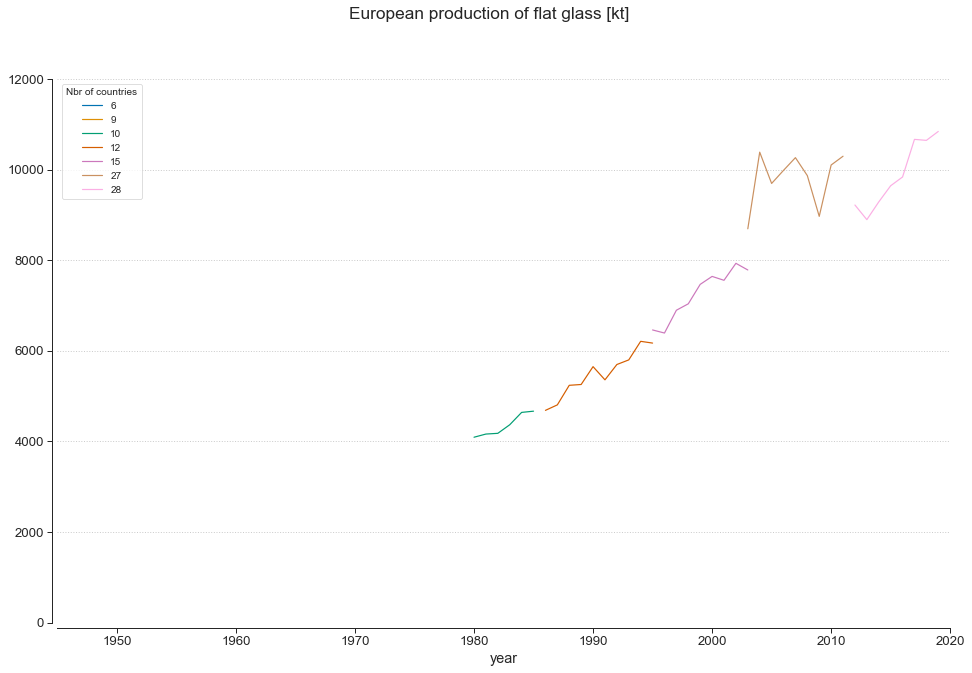

In [16]:
# Plot the European production of flat glass:
fig, ax = plt.subplots()

sns.lineplot(data=eu_df.reset_index(),
             x='year', y='Production [kt]',
             hue='Nbr of countries',
             palette='colorblind',
             ax=ax)

ax.yaxis.label.set_visible(False)
ax.set_xlim(1945, 2020)
ax.set_ylim(0, 12000)

ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

fig.suptitle('European production of flat glass [kt]')
sns.despine(offset=5)
plt.show()

## Flat Glass Consumption

In [17]:
# Estimate the consumption of flat glass in EU:
eu_df['Consumption [kt]'] = (eu_df['Production [kt]']
                             + eu_df['Import [kt]']
                             - eu_df['Export [kt]'])

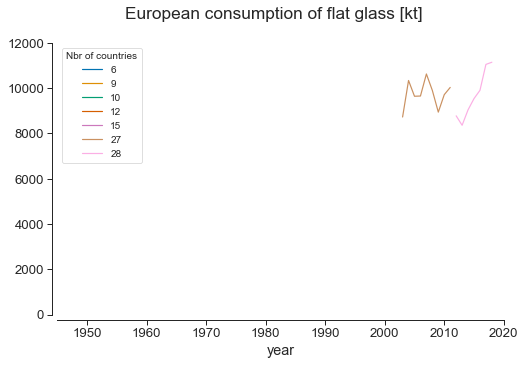

In [18]:
# Plot the European consumption of flat glass:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=eu_df.reset_index(),
             x='year', y='Consumption [kt]',
             hue='Nbr of countries',
             palette='colorblind',
             ax=ax)

ax.yaxis.label.set_visible(False)
ax.set_xlim(1945, 2020)
ax.set_ylim(0, 12000)

fig.suptitle('European consumption of flat glass [kt]')
sns.despine(offset=5)
plt.show()

## Architectural Flat Glass Production

In [19]:
# Share of architectural glass in the European production of flat glass:
eu_bldgshare = eu_prod[['bldg glass/flat glass, %']].copy()
eu_bldgshare = eu_bldgshare.dropna()

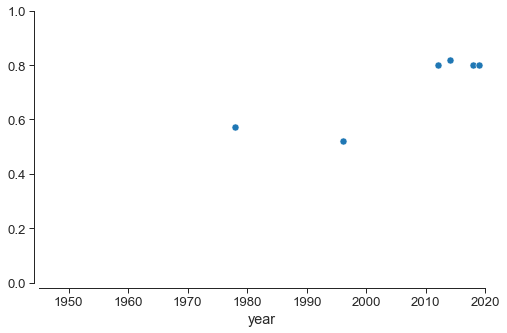

In [20]:
# Plot share of architectural glass/total flat glass:
fig, ax = plt.subplots(figsize=(8, 5))

sns.scatterplot(data=eu_bldgshare.reset_index(),
                x='year', y='bldg glass/flat glass, %',
                markers="o", s=50, ax=ax)

ax.yaxis.label.set_visible(False)
ax.set_xlim(1945, 2020)
ax.set_ylim(0, 1)

sns.despine(offset=5)

In [21]:
# Linear interpolation according to available data:
eu_df['bldg glass/flat glass, %'] = (eu_prod['bldg glass/flat glass, %']
                                     .interpolate(method="linear",
                                                  limit_area='inside'))

In [22]:
# Calculation of the European production of architectural flat glass:
eu_df['Architectural glass production [kt]'] = (eu_df['Production [kt]']
                                                * eu_df['bldg glass/flat glass, %'])

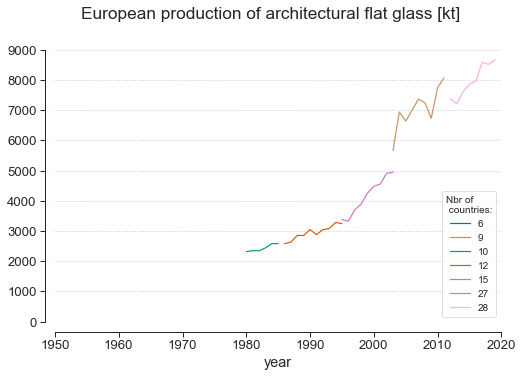

In [23]:
# Plot the European production of architectural flat glass:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=eu_df.reset_index(),
             x='year', y='Architectural glass production [kt]',
             hue='Nbr of countries',
             palette='colorblind',
             ax=ax)

# Add legend:
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='lower right', ncol=1,
          title='Nbr of \n countries:', bbox_to_anchor=(1, 0))

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 9000)
ax.yaxis.label.set_visible(False)
ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

fig.suptitle('European production of architectural flat glass [kt]', y=1)
sns.despine(offset=10)
plt.show()

## Summary

In [24]:
# Assess the annual growth:
eu_df['Growth, flat glass [%]'] = eu_df['Production [kt]'].pct_change()
eu_df['Growth, arch glass [%]'] = (eu_df['Architectural glass production [kt]']
                                   .pct_change())

In [25]:
eu_df['Growth, flat glass [%]'].loc[10]*100

year
1980     NaN
1981    1.71
1982    0.38
1983    4.53
1984    6.25
1985    0.58
Name: Growth, flat glass [%], dtype: float64

In [26]:
# Growth of flat glass production in eu_df from 1980 to 1995:
a = (eu_df['Growth, flat glass [%]'].loc[10:12].mean()*100)
b = (eu_df['Growth, arch glass [%]'].loc[10:12].mean()*100)
print(f'Flat glass production growth in eu_df, 1980-1995:\n {a:.2f}%\n',
      f'Architectural glass production growth in eu_df, 1980-1995:\n {b:.2f}%')

# Growth of flat glass production in eu_df from 1995 to 2003:
c = (eu_df['Growth, flat glass [%]'].loc[12:15].mean()*100)
d = (eu_df['Growth, arch glass [%]'].loc[12:15].mean()*100)
print(f'Flat glass production growth in eu_df, 1995-2003:\n {c:.2f}%\n',
      f'Architectural glass production growth in eu_df, 1995-2003:\n {d:.2f}%')

# Growth of flat glass production in eu_df from 2003 to 2020:
e = (eu_df['Growth, arch glass [%]'].loc[27:28].mean()*100)
print(f'Flat glass production growth in eu_df, 2003-2020:\n {e:.2f}%')

Flat glass production growth in eu_df, 1980-1995:
 2.84%
 Architectural glass production growth in eu_df, 1980-1995:
 2.33%
Flat glass production growth in eu_df, 1995-2003:
 2.80%
 Architectural glass production growth in eu_df, 1995-2003:
 3.57%
Flat glass production growth in eu_df, 2003-2020:
 3.65%


In [27]:
# Key dates for the changes in the MFA scope, i.e. EU enlargement:
EU_KDATES = {'EU10': 1981, 'EU12': 1986, 'EU15': 1995,
             'EU27': 2003, 'EU28': 2012}

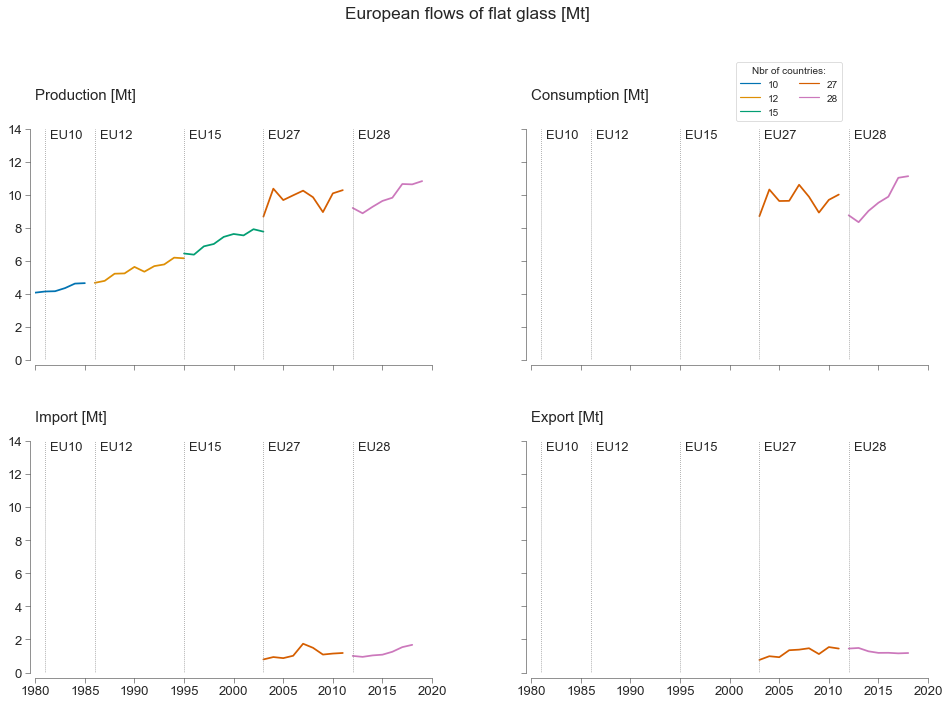

In [28]:
# Plot a synthesis of the results concerning European flat glass flows:
data1 = ['Production', 'Consumption']
data2 = ['Import', 'Export']

fig, axes = plt.subplots(nrows=2, ncols=2,
                         sharex=True, sharey=True,
                         figsize=(16, 10))

# Plot production and consumption:
for col, data in enumerate(data1):
    ax = axes[0][col]
    sns.lineplot(data=eu_df.loc[10:28].reset_index(),
                 x='year', y=f"{data} [kt]",
                 hue='Nbr of countries',
                 palette='colorblind', linewidth=1.75,
                 ax=ax)

    # Plot lines highlighting changes in the scope, i.e., EU enlargement:
    for y, x in EU_KDATES.items():
        ax.axvline(x=x, c='grey', linestyle=':', linewidth=0.75)
        ax.text(x+0.5, 14000, f"{y}", fontsize=13,
                verticalalignment='top')

    style_ax(ax)

    # Divide by 1000 the y-axis, results in Mt:
    ax.yaxis.set_major_formatter(y_1000)

    ax.set_title(f"{data} [Mt]", pad=30, loc='left')
    #ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
    ax.get_legend().remove()
    ax.yaxis.label.set_visible(False)

# Plot import and export below:
for col, data in enumerate(data2):
    ax = axes[1][col]
    sns.lineplot(data=eu_df.loc[10:28].reset_index(),
                 x='year', y=f"{data} [kt]",
                 hue='Nbr of countries',
                 palette='colorblind', linewidth=1.75,
                 ax=ax)

    # Plot lines highlighting changes in the scope, i.e., EU enlargement:
    for y, x in EU_KDATES.items():
        ax.axvline(x=x, c='grey', linestyle=':', linewidth=0.75)
        ax.text(x+0.5, 14000, f"{y}", fontsize=13,
                verticalalignment='top')

    style_ax(ax)

    # Divide by 1000 the y-axis, results in Mt:
    ax.yaxis.set_major_formatter(y_1000)

    ax.set_title(f"{data} [Mt]", pad=20, loc='left')
    #ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
    ax.get_legend().remove()
    ax.yaxis.label.set_visible(False)


# Add legend:
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=2,
           title='Nbr of countries:',
           bbox_to_anchor=(0.83, 0.98))

ax.set_xlim(1980, 2020)
ax.set_ylim(0, 14000)

fig.suptitle("European flows of flat glass [Mt]", y=1.05)
fig.subplots_adjust(wspace=0.25, hspace=0.35)

sns.despine(offset=5)
plt.show()

if export:
    # Save image:
    fig.savefig(os.path.join(path_img, 'AppendixB_EU_FlatGlassFlows.png'),
                dpi=600, bbox_inches='tight')
    fig.savefig(os.path.join(path_img, 'AppendixB_EU_FlatGlassFlows.pdf'),
                bbox_inches='tight')

In [29]:
# Number of countries for trend curves:
EU_COUNTRIES = [(10, 15), (27, 28)]

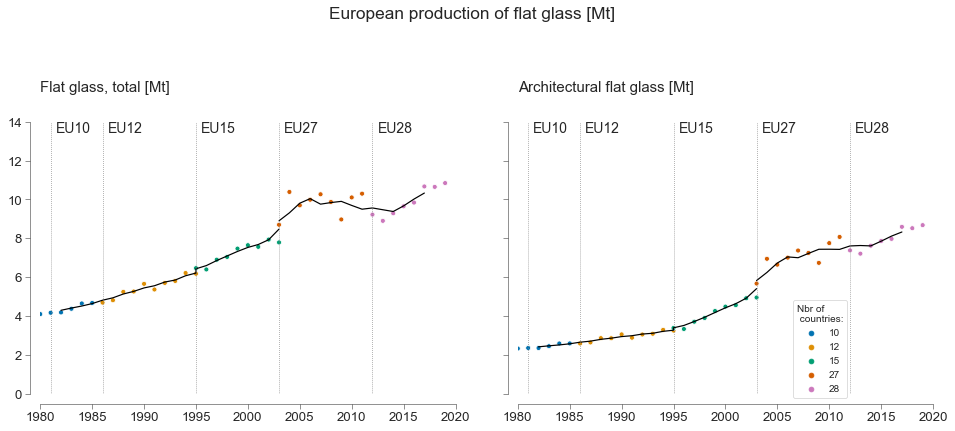

In [30]:
# Plot the European production of flat glass (total and only arch glass):
data = ['Production', 'Architectural glass production']

# Plot two figures:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         sharex=True, sharey=True,
                         figsize=(16, 5))

for col, data in enumerate(data):
    for i, j in EU_COUNTRIES:
        ax = axes[col]
        # Plot the trend curve for flat glass production:
        ax.plot(eu_df.interpolate().rolling(5, center=True).mean().loc[i:j]
                .reset_index(level='Nbr of countries')
                .sort_values(by=['year'])
                [f"{data} [kt]"],
                c='black', linestyle='-')

    # Plot data gathered from literature review:
    sns.scatterplot(data=eu_df.loc[10:28].reset_index(),
                    x='year', y=f"{data} [kt]",
                    hue='Nbr of countries',
                    palette='colorblind',
                    marker='.', s=100,
                    ax=ax)
    ax.get_legend().remove()

    # Divide by 1000 the y-axis, results in Mt:
    ax.yaxis.set_major_formatter(y_1000)

    if col == 0:
        ax.set_title('Flat glass, total [Mt]', pad=30, loc='left')
        ax.yaxis.label.set_visible(False)
    else:
        ax.set_title('Architectural flat glass [Mt]', pad=30, loc='left')

    # Plot lines highlighting changes in the scope, i.e., EU enlargement:
    for y, x in EU_KDATES.items():
        ax.axvline(x=x, c='grey', linestyle=':', linewidth=0.75)
        ax.text(x+0.5, 14000, f"{y}", fontsize=14,
                verticalalignment='top')

    style_ax(ax)
    ax.set_xlim(1980, 2020)
    ax.set_ylim(0, 14000)

# Add legend:
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, ncol=1, loc='lower right',
           title='Nbr of \n countries:',
           bbox_to_anchor=(0.83, 0.1))

plt.suptitle('European production of flat glass [Mt]', weight='light', y=1.2)

fig.subplots_adjust(wspace=0.15)

sns.despine(offset=10)
plt.show()

if export:
    # Save image:
    fig.savefig(os.path.join(path_img, 'Fig2_EU_FlatGlassProd.png'),
                dpi=600, bbox_inches='tight')
    fig.savefig(os.path.join(path_img, 'Fig2_EU_FlatGlassProd.pdf'),
                bbox_inches='tight')

# Flat Glass Production in France and Belgium

## Creating a Dataframe for Flat Glass Flows

In [31]:
# Create a DataFrame from production datasets:
fr_prod = fr_data.parse('prod').set_index('year')
be_prod = be_data.parse('prod').set_index('year')

In [32]:
# Create DataFrames from import and export datasets:
fr_imp = fr_data.parse('import').set_index('year')
fr_exp = fr_data.parse('export').set_index('year')

be_imp = be_data.parse('import').set_index('year')
be_exp = be_data.parse('export').set_index('year')

In [33]:
# Create a unique DataFrame for FR and BE flat glass flows:
be_fr = pd.concat([fr_prod['flat glass, kt'], be_prod['flat glass, kt'],
                   fr_imp['flat glass, kt'], be_imp['flat glass, kt'],
                   fr_exp['flat glass, kt'], be_exp['flat glass, kt']],
                  axis=1, keys=[('Production [kt]', 'France'),
                                ('Production [kt]', 'Belgium'),
                                ('Import [kt]', 'France'),
                                ('Import [kt]', 'Belgium'),
                                ('Export [kt]', 'France'),
                                ('Export [kt]', 'Belgium')],
                  names=['Info', 'Country']).stack()

be_fr = be_fr.unstack()

In [34]:
# Overview of FR and BE dataframe, flat glass flows:
be_fr

Info    Export [kt]         Import [kt]        Production [kt]       
Country     Belgium  France     Belgium France         Belgium France
year                                                                 
1945            NaN     NaN         NaN    NaN             NaN  108.3
1946            NaN     NaN         NaN    NaN             NaN  173.8
1947            NaN     NaN         NaN    NaN             NaN  198.3
1948            NaN     NaN         NaN    NaN             NaN  220.2
1949            NaN     NaN         NaN    NaN             NaN  191.3
...             ...     ...         ...    ...             ...    ...
2016         499.79  300.84      216.27  370.0             NaN    NaN
2017         547.19  333.31      230.96  401.0             NaN    NaN
2018         547.76  349.18      228.65  355.0             NaN    NaN
2019         986.33  451.42      254.22  352.0             NaN    NaN
2020            NaN     NaN         NaN  349.0             NaN    NaN

[76 rows x 6 columns]

## Production of Flat Glass

In [35]:
countries = ['Belgium', 'France']

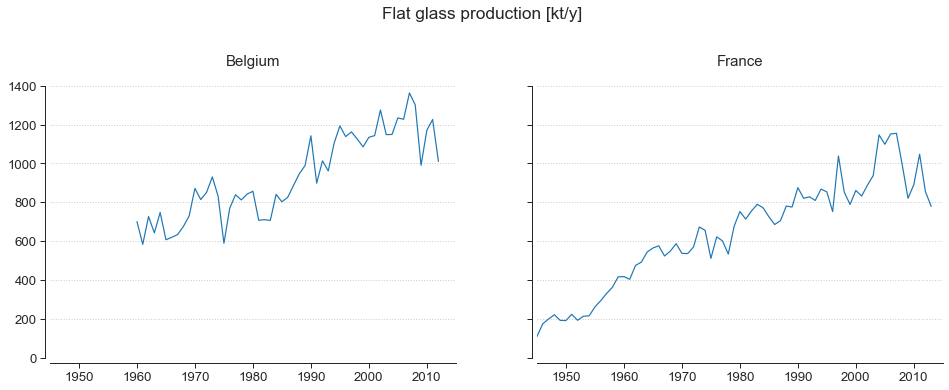

In [36]:
# Plot the BE and FR production of flat glass:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(16, 5),
                         sharex=True, sharey=True)

for i, (ax, country) in enumerate(zip(axes.flatten(), countries)):
    ax.plot(be_fr.index,
            be_fr['Production [kt]'][country])

    ax.set_title(country, pad=20)
    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

ax.set_xlim(1945, 2015)
ax.set_ylim(0, 1400)

fig.suptitle('Flat glass production [kt/y]', y=1.1)
sns.despine(offset=5)
plt.show()

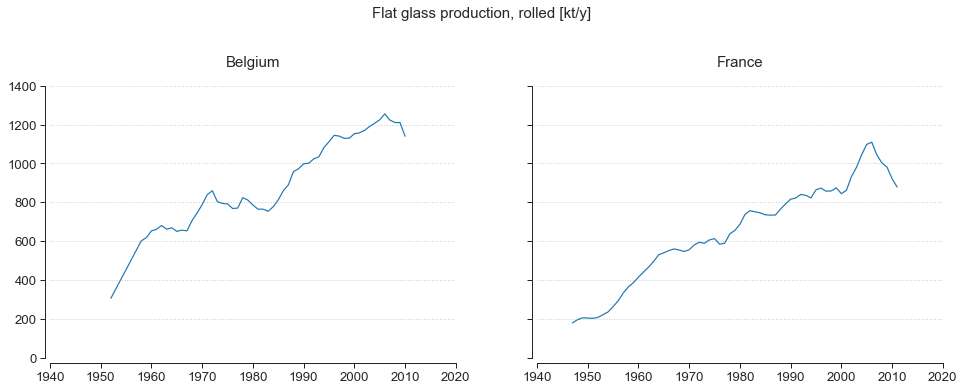

In [37]:
# Plot a moving average for flat glass production:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(16, 5),
                         sharex=True, sharey=True)

for i, (ax, country) in enumerate(zip(axes.flatten(), countries)):
    ax.plot(be_fr.index,
            be_fr['Production [kt]'][country]
            # Linear interpolation for flat glass production:
            .interpolate(method="linear", limit_area='inside')
            # Rolling flat glass production according to a 5-year mean:
            .rolling(5, center=True).mean())

    ax.set_title(country, y=1.05)
    ax.set_xlim(1940, 2020)
    ax.set_ylim(0, 1400)
    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

fig.suptitle('Flat glass production, rolled [kt/y]', fontsize=15, y=1.1)
sns.despine(offset=5)
plt.show()

## Consumption of Flat Glass

In [38]:
# Caculate import and export ratios relative to production:
be_fr = be_fr.stack()

be_fr['Import Ratio'] = be_fr['Import [kt]'] / be_fr['Production [kt]']
be_fr['Export Ratio'] = be_fr['Export [kt]'] / be_fr['Production [kt]']

be_fr = be_fr.unstack()

In [39]:
ratios = ['Export', 'Import']

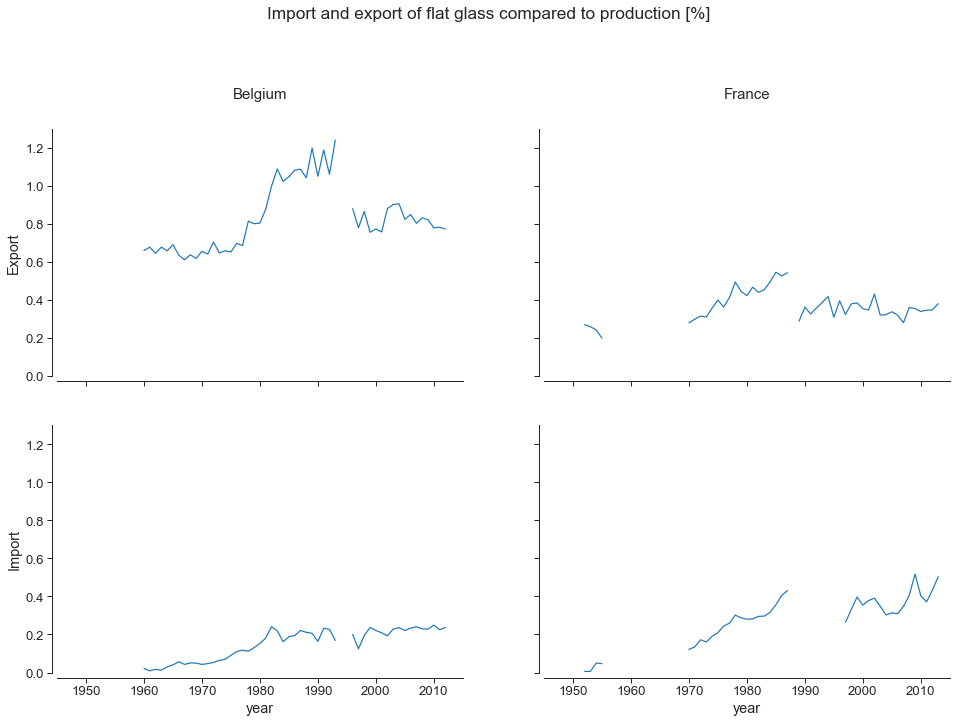

In [40]:
# Plot import and export ratios for FR and BE:
nrows = len(ratios)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True)

for row, ratio in enumerate(ratios):
    for col, country in enumerate(countries):
        ax = axes[row][col]
        (be_fr[(f"{ratio} Ratio", country)].plot(ax=ax))

        if row == 0:
            ax.set_title(country, y=1.1)
        if col == 0:
            ax.set_ylabel(ratio)


ax.set_ylim(0, 1.3)
ax.set_xlim(1945, 2015)

fig.suptitle("Import and export of flat glass compared to production [%]",
             y=1.05)
sns.despine(offset=5)
plt.show()

In [41]:
# Interpolation for missing data:
cols = [x for x in be_fr.columns if x[0] in ['Import Ratio', 'Export Ratio']]

be_fr[cols] = (be_fr[cols].interpolate(method='linear'))

In [42]:
be_fr.loc[1950:1960, cols]

Info    Import Ratio           Export Ratio       
Country      Belgium    France      Belgium France
year                                              
1950             NaN       NaN          NaN   0.29
1951             NaN       NaN          NaN   0.28
1952             NaN  5.99e-03          NaN   0.27
1953             NaN  5.33e-03          NaN   0.26
1954             NaN  4.99e-02          NaN   0.24
1955             NaN  4.64e-02          NaN   0.20
1956             NaN  4.47e-02          NaN   0.17
1957             NaN  4.30e-02          NaN   0.15
1958             NaN  4.14e-02          NaN   0.18
1959             NaN  3.97e-02          NaN   0.21
1960            0.02  3.80e-02         0.66   0.24

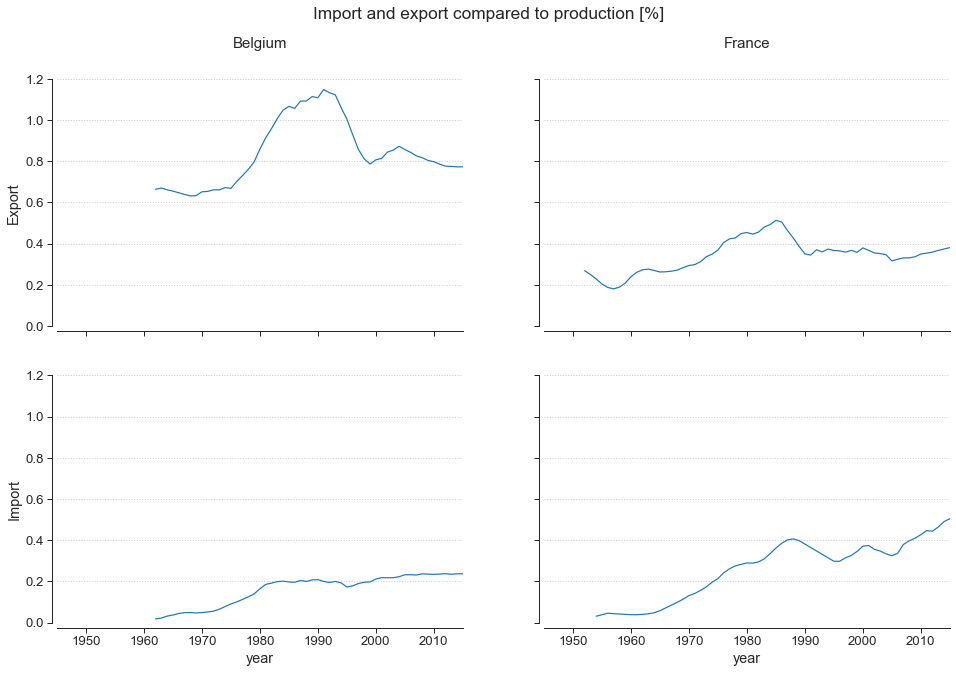

In [43]:
# Plot import and export ratios, w/ a moving average (5-y. window length):
nrows = len(ratios)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True)

for row, ratio in enumerate(ratios):
    for col, country in enumerate(countries):
        ax = axes[row][col]
        (be_fr[(f"{ratio} Ratio", country)]
         .rolling(5, center=True).mean()
         .plot(ax=ax))

        ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
        if row == 0:
            ax.set_title(country, y=1.1)
        if col == 0:
            ax.set_ylabel(ratio)

ax.set_xlim(1945, 2015)
ax.set_ylim(0, 1.2)

fig.suptitle("Import and export compared to production [%]")
sns.despine(offset=5)
plt.show()

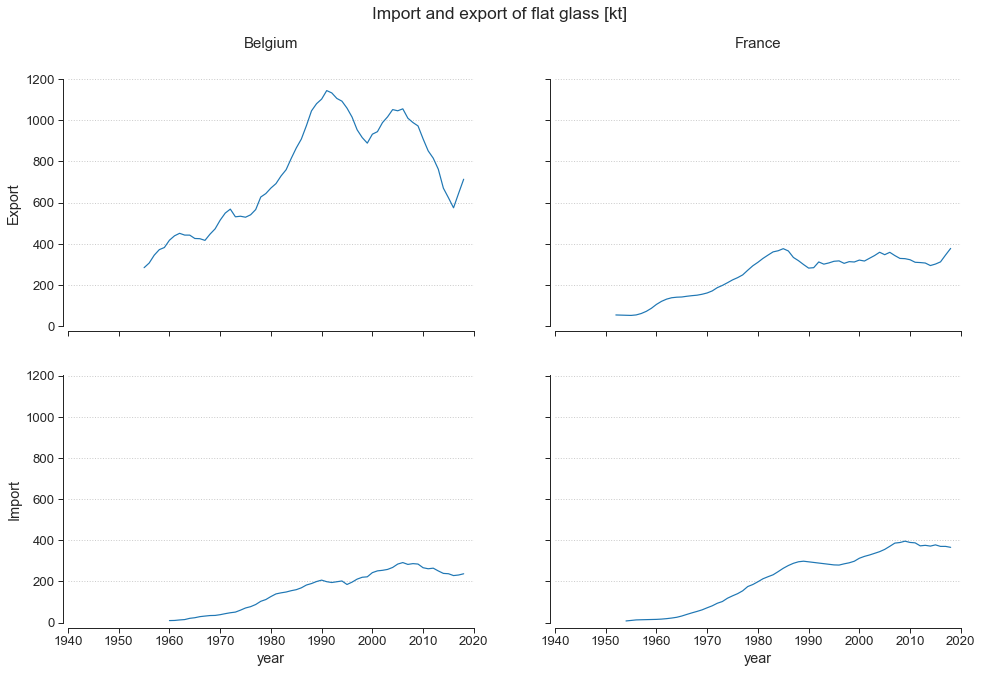

In [44]:
# Plot total import and export flows, moving average w/ a 5-y. window length:
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(16, 10))

for row, ratio in enumerate(ratios):
    for col, country in enumerate(countries):
        ax = axes[row][col]
        (be_fr[(f"{ratio} [kt]", country)]
         .interpolate(method='linear')
         .rolling(5, center=True).mean()
         .plot(ax=ax))

        ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
        if row == 0:
            ax.set_title(country, y=1.1)
        if col == 0:
            ax.set_ylabel(ratio)

ax.set_xlim(1940, 2020)
ax.set_ylim(ymin=0)

fig.suptitle("Import and export of flat glass [kt]")
sns.despine(offset=5)
plt.show()

In [45]:
# Calulate the total consumption of flat glass in BE and FR:
be_fr = be_fr.stack()

be_fr['Consumption [kt]'] = (be_fr['Production [kt]']
                             + be_fr['Import Ratio']
                             * be_fr['Production [kt]']
                             - be_fr['Export Ratio']
                             * be_fr['Production [kt]'])

be_fr = be_fr.unstack()

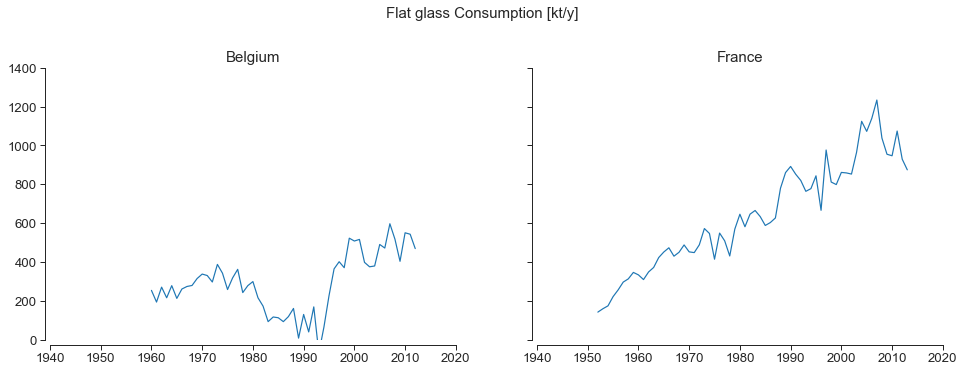

In [46]:
# Plot total consumption of flat glass:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(16, 5),
                         sharex=True, sharey=True)

for i, (ax, country) in enumerate(zip(axes.flatten(), countries)):

    ax.plot(be_fr.index,
            be_fr['Consumption [kt]'][country])
    ax.set_title(country)

ax.set_xlim(1940, 2020)
ax.set_ylim(0, 1400)

fig.suptitle('Flat glass Consumption [kt/y]', fontsize=15, y=1.05)
sns.despine(offset=5)
plt.show()

In [47]:
# Create a DataFrame for the FR and BE demography:
fr_pop = fr_data.parse('Population').set_index('year')
be_pop = be_data.parse('Population').set_index('year')

In [48]:
# Create a single DataFrame for French and Belgian population since 1945:
be_fr_pop = pd.concat([fr_pop['Population, x1000'],
                       be_pop['Population, x1000']],
                      axis=1, keys=[('Population [x1000]', 'France'),
                                    ('Population [x1000]', 'Belgium')],
                      names=['Info', 'Country']).stack()

be_fr_pop = be_fr_pop.unstack()

In [49]:
# Linear interpolation for a few missing data (BE, from 1947 to 1959):
be_fr_pop[('Population [x1000]', 'Belgium')] = (
    be_fr_pop[('Population [x1000]', 'Belgium')].interpolate(method='linear')
)

In [50]:
# Estimate the consumption per capita:
for country in countries:
    be_fr[('Consumption [kg/cap]', country)] = (
        be_fr[('Consumption [kt]', country)]
        / be_fr_pop[('Population [x1000]', country)] * 1000
    )

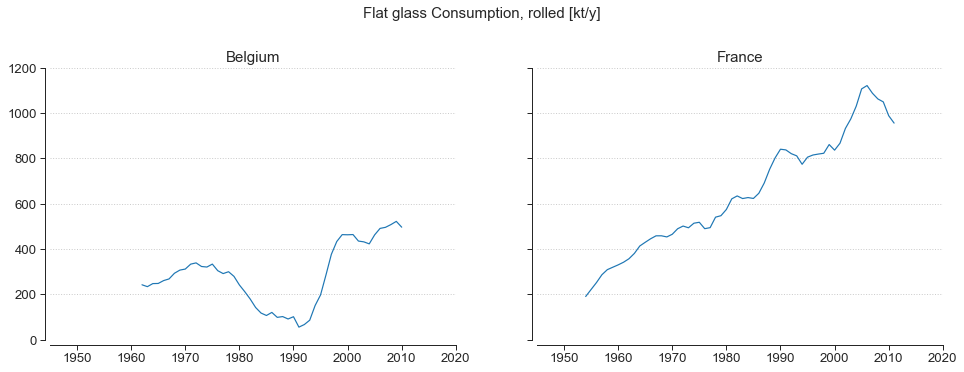

In [51]:
# Linear interpolation for flat glass consumption
# and moving average with a 5-year window length:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(16, 5),
                         sharex=True, sharey=True)

for i, (ax, country) in enumerate(zip(axes.flatten(), countries)):
    ax.plot(be_fr.index,
            be_fr['Consumption [kt]'][country]
            .interpolate(method="linear", limit_area='inside')
            .rolling(5, center=True).mean())
    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
    ax.set_title(country)

ax.set_xlim(1945, 2020)
ax.set_ylim(0, 1200)

fig.suptitle('Flat glass Consumption, rolled [kt/y]', fontsize=15, y=1.05)
sns.despine(offset=5)
plt.show()

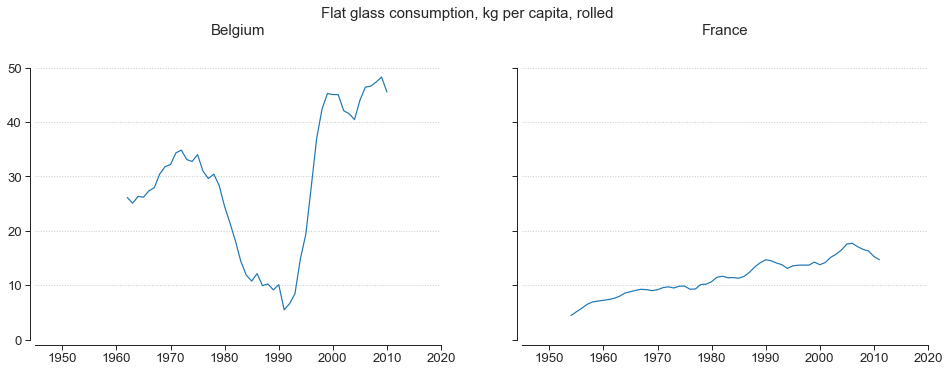

In [52]:
# Linear interpolation for flat glass consumption per capita
# and moving average with a 5-y. window length:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(16, 5),
                         sharex=True, sharey=True)

for i, (ax, country) in enumerate(zip(axes.flatten(), countries)):
    ax.plot(be_fr.index,
            be_fr['Consumption [kg/cap]'][country]
            .interpolate(method="linear", limit_area='inside')
            .rolling(5, center=True).mean())

    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
    ax.set_title(country, y=1.1)

ax.set_xlim(1945, 2020)
ax.set_ylim(0, 50)

fig.suptitle('Flat glass consumption, kg per capita, rolled',
             fontsize=15, y=1.05)
sns.despine(offset=5)
plt.show()

## Production of Architectural Flat Glass

In [53]:
# Share of building glass relative to the total flat glass production in FR:
share_fr = fr_prod[['bldg glass/flat glass, %']].dropna()

print(share_fr.isnull().sum())
share_fr

bldg glass/flat glass, %    0
dtype: int64


,"bldg glass/flat glass, %"
year,
1945,0.90
1952,0.80
1962,0.68
1968,0.50
1980,0.50
1994,0.50
2002,0.52
2004,0.49
2009,0.52


In [54]:
# Calculate the main parameters of a regression curve, second order
# to interpolate "arch glass/total flat glass" ratio, with uncertainties:
share_fr['Trend'] = fr_prod[['bldg glass/flat glass, %']].copy()

share_fr = share_fr.reset_index()

x = np.array(list(share_fr['year']))
y = np.array(list(share_fr['Trend']))

share_fr = share_fr.set_index('year')

# Order of the regression:
n = 3

# Polynomial coefficients and covariance matrix:
coeffs, cov = np.polyfit(x, y, n, cov=True)

results = {}
results['Polynomial'] = coeffs.tolist()
results['Covariance'] = cov.tolist()

# Interpolation:
t = np.linspace(1945, 2020, 76)

# Matrix with rows 1, t, t**2...:
TT = np.vstack([t**(n-i) for i in range(1+n)]).T

# Matrix multiplication for the polynomial values:
z = np.dot(TT, coeffs)

# Standard deviations (sqrt of diagonal):
sig = np.sqrt(
    np.diag(
        np.dot(TT, np.dot(cov, TT.T))
    ))

# r-squared
p = np.poly1d(coeffs)

# fit values, and mean
yhat = p(x)                      # vector y = p(z) for z in x
ybar = np.sum(y)/len(y)          # mean of y data
SSres = np.sum((yhat-ybar)**2)   # residual sum of squares
SStot = np.sum((y - ybar)**2)    # total sum squares

results['Coefficient of determination'] = SSres / SStot

results

{'Polynomial': [-2.378960893414362e-06,
  0.014301359629274039,
  -28.656983590865888,
  19140.70797173813],
 'Covariance': [[2.8029866613415203e-12,
   -1.6645777335936083e-08,
   3.2948302953039774e-05,
   -0.021737417444942602],
  [-1.6645777335958778e-08,
   9.88533429177357e-05,
   -0.19567014611392025,
   129.09330281953902],
  [3.294830295312971e-05,
   -0.1956701461141876,
   387.3129582861321,
   -255532.078955934],
  [-0.021737417445031697,
   129.09330281989222,
   -255532.0789562839,
   168590499.05965033]],
 'Coefficient of determination': 0.9311453347637837}

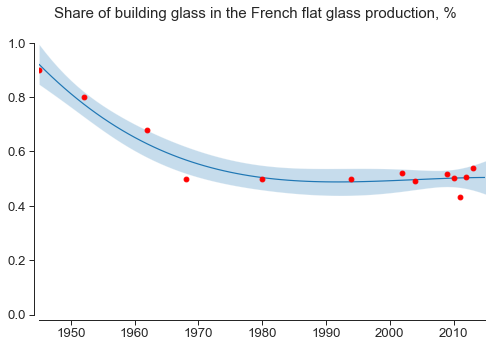

In [55]:
# Scatterplot of the ratio and plot of a regression curve, 2nd order:
fig, ax = plt.subplots(figsize=(8, 5))

ax.fill_between(t, z+1.96*sig, z-1.96*sig, alpha=0.25)
ax.plot(t, z, '-')
ax.plot(x, y, 'ro')

ax.set_ylim(0, 1)
ax.set_xlim(1945, 2015)

fig.suptitle('Share of building glass in the French flat glass production, %',
             fontsize=15)
sns.despine(offset=5)
plt.show()

In [56]:
# Create a dataframe for ratio arch glass/tot flat glass:
bldg_share = fr_prod[['bldg glass/flat glass, %']].copy()

# Interpolate values according to
# nonlinear regression previously estimated
bldg_share['Mean ratio arch glass/flat glass, %'] = z.tolist()

# Integrate standard deviation in FR_Prod
bldg_share['std for ratio arch glass/flat glass'] = sig.tolist()

bldg_share

,"bldg glass/flat glass, %","Mean ratio arch glass/flat glass, %",std for ratio arch glass/flat glass
year,,,
1945,0.9,0.92,0.04
1946,NaN,0.90,0.03
1947,NaN,0.87,0.03
1948,NaN,0.85,0.03
1949,NaN,0.83,0.03
...,...,...,...
2016,NaN,0.50,0.04
2017,NaN,0.50,0.04
2018,NaN,0.50,0.05


In [57]:
# Estimate architectural flat glass production in FR and BE:
for country in countries:
    be_fr[('Architectural glass production [kt]', country)] = (
        be_fr[('Production [kt]', country)]
        * bldg_share['Mean ratio arch glass/flat glass, %']
    )

for country in countries:
    be_fr[('std for arch glass production', country)] = (
        be_fr[('Production [kt]', country)]
        * bldg_share['std for ratio arch glass/flat glass']
    )

In [58]:
# Calculate data for uncertainties according to the standard deviaton, 95%:
x = np.array(be_fr.index)

yminFR = np.array(be_fr[('Architectural glass production [kt]', 'France')]
                  .interpolate(method="linear", limit_area='inside')
                  + 1.96
                  * be_fr[('std for arch glass production', 'France')]
                  .interpolate(method="linear", limit_area='inside'))

ymaxFR = np.array(be_fr[('Architectural glass production [kt]', 'France')]
                  .interpolate(method="linear", limit_area='inside')
                  - 1.96
                  * be_fr[('std for arch glass production', 'France')]
                  .interpolate(method="linear", limit_area='inside'))

yminBE = np.array(be_fr[('Architectural glass production [kt]', 'Belgium')]
                  .interpolate(method="linear", limit_area='inside')
                  + 1.96
                  * be_fr[('std for arch glass production', 'Belgium')]
                  .interpolate(method="linear", limit_area='inside'))

ymaxBE = np.array(be_fr[('Architectural glass production [kt]', 'Belgium')]
                  .interpolate(method="linear", limit_area='inside')
                  - 1.96
                  * be_fr[('std for arch glass production', 'Belgium')]
                  .interpolate(method="linear", limit_area='inside'))

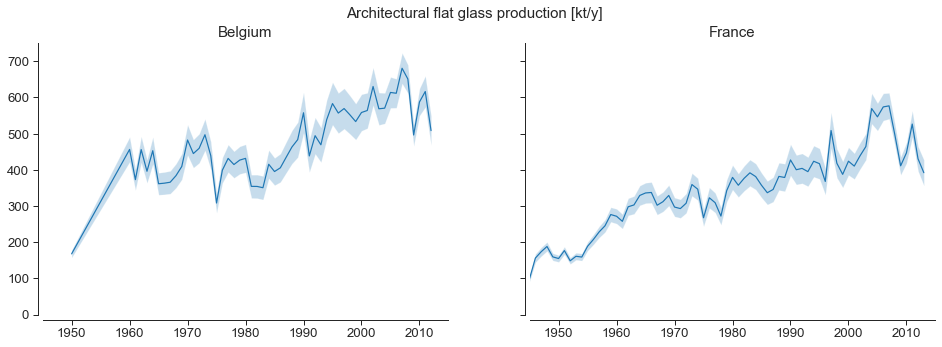

In [59]:
# Plot architectural flat glass production with uncertainties (95%):
fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(16, 5),
                         sharex=True, sharey=True)

for i, (ax, country) in enumerate(zip(axes.flatten(), countries)):

    ax.plot(be_fr.index,
            be_fr['Architectural glass production [kt]'][country]
            .interpolate(method="linear", limit_area='inside'))

    if country == 'France':
        ax.fill_between(x, yminFR, ymaxFR, alpha=0.25)
    elif country == 'Belgium':
        ax.fill_between(x, yminBE, ymaxBE, alpha=0.25)

    ax.set_title(country)
    ax.set_xlim(1945, 2015)
    ax.set_ylim(ymin=0)

fig.suptitle('Architectural flat glass production [kt/y]', fontsize=15)
sns.despine(offset=5)
plt.show()

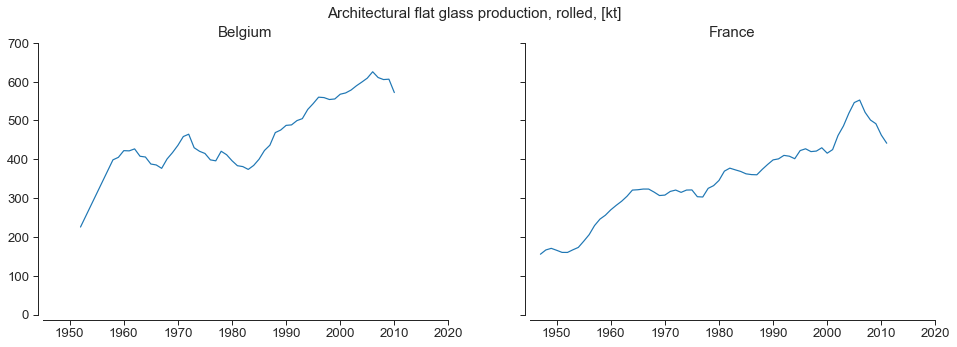

In [60]:
# Plot architectural flat glass prod, with a moving average, no uncertainty:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(16, 5),
                         sharex=True, sharey=True)

for i, (ax, country) in enumerate(zip(axes.flatten(), countries)):
    ax.plot(be_fr.index,
            be_fr['Architectural glass production [kt]'][country]
            .interpolate(method="linear", limit_area='inside')
            .rolling(5, center=True).mean())

    ax.set_title(country)
    ax.set_xlim(1945, 2020)
    ax.set_ylim(0, 700)

fig.suptitle('Architectural flat glass production, rolled, [kt]', fontsize=15)
sns.despine(offset=5)
plt.show()

In [61]:
# Calculate data for uncertainties according to the standard deviaton, 95%,
# and undertake a moving average with a 5-y. window length:
ymin_fr = np.array((be_fr[('Architectural glass production [kt]', 'France')]
                   .interpolate(method="linear", limit_area='inside')
                   .rolling(5, center=True).mean())
                   + 1.96*be_fr[('std for arch glass production', 'France')]
                   .interpolate(method="linear", limit_area='inside')
                   )
ymax_fr = np.array((be_fr[('Architectural glass production [kt]', 'France')]
                   .interpolate(method="linear", limit_area='inside')
                   .rolling(5, center=True).mean())
                   - 1.96*be_fr[('std for arch glass production', 'France')]
                   .interpolate(method="linear", limit_area='inside')
                   )

ymin_be = np.array((be_fr[('Architectural glass production [kt]', 'Belgium')]
                   .interpolate(method="linear", limit_area='inside')
                   .rolling(5, center=True).mean())
                   + 1.96*be_fr[('std for arch glass production', 'Belgium')]
                   .interpolate(method="linear", limit_area='inside')
                   )
ymax_beBE = np.array((be_fr[('Architectural glass production [kt]', 'Belgium')]
                      .interpolate(method="linear", limit_area='inside')
                      .rolling(5, center=True).mean())
                     - 1.96*be_fr[('std for arch glass production', 'Belgium')]
                     .interpolate(method="linear", limit_area='inside')
                     )

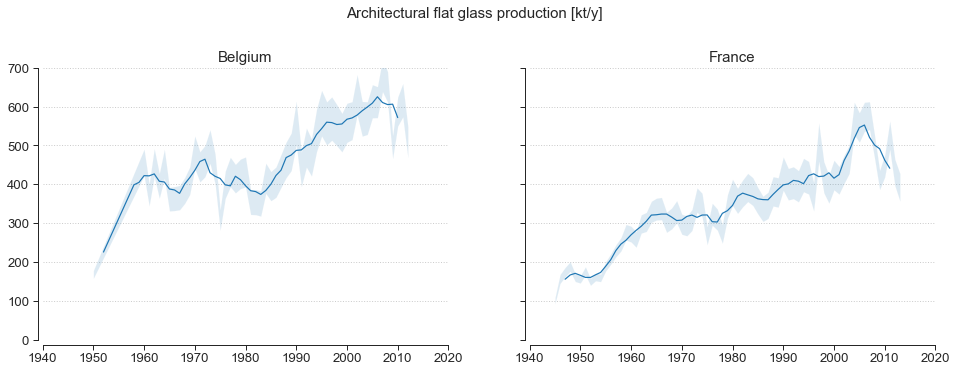

In [62]:
# Plot architectural flat glass prod, with a moving average and uncertainties:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(16, 5),
                         sharex=True, sharey=True)

for i, (ax, country) in enumerate(zip(axes.flatten(), countries)):
    ax.plot(be_fr.index,
            (be_fr['Architectural glass production [kt]'][country]
             .interpolate(method="linear", limit_area='inside')
             .rolling(5, center=True).mean()))

    if country == 'France':
        ax.fill_between(x, yminFR, ymaxFR, alpha=0.15)
    elif country == 'Belgium':
        ax.fill_between(x, yminBE, ymaxBE, alpha=0.15)

    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
    ax.set_title(country)
    ax.set_xlim(1940, 2020)
    ax.set_ylim(0, 700)

fig.suptitle('Architectural flat glass production [kt/y]',
             fontsize=15, y=1.05)
sns.despine(offset=5)
plt.show()

## Consumption of Architectural Flat Glass

In [63]:
# Calculate Belgian and French consumption of architectural flat glass:
be_fr = be_fr.stack()

be_fr['Architectural glass consumption [kt]'] = (
    be_fr['Architectural glass production [kt]']
    + be_fr['Import Ratio'] * be_fr['Architectural glass production [kt]']
    - be_fr['Export Ratio'] * be_fr['Architectural glass production [kt]']
)

be_fr = be_fr.unstack()

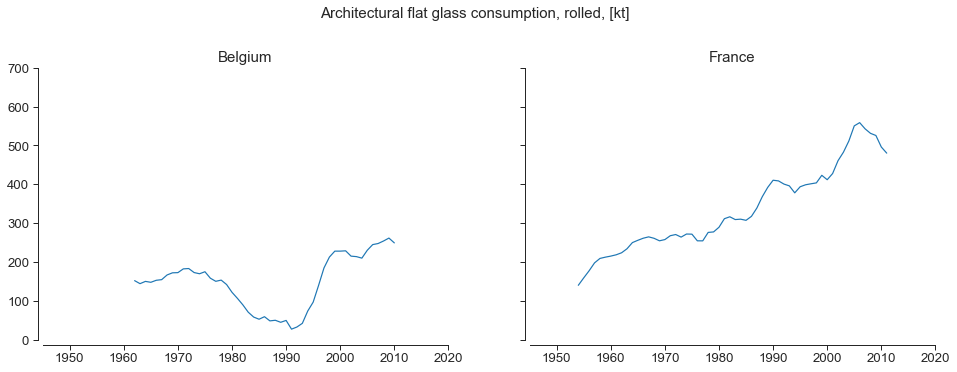

In [64]:
# Interpolate and calculate a mean average for architectural glass consumption
# and plot:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(16, 5),
                         sharex=True, sharey=True)

for i, (ax, country) in enumerate(zip(axes.flatten(), countries)):

    ax.plot(be_fr.index,
            be_fr['Architectural glass consumption [kt]'][country]
            .interpolate(method="linear", limit_area='inside')
            .rolling(5, center=True).mean())

    ax.set_title(country)
    ax.set_xlim(1945, 2020)
    ax.set_ylim(0, 700)

fig.suptitle('Architectural flat glass consumption, rolled, [kt]',
             fontsize=15, y=1.05)
sns.despine(offset=5)
plt.show()

In [65]:
# Estimate the consumption per capita:
for country in countries:
    be_fr[('Architectural glass consumption [kg/cap]', country)] = (
        be_fr[('Architectural glass consumption [kt]', country)]
        / be_fr_pop[('Population [x1000]', country)] * 1000
    )

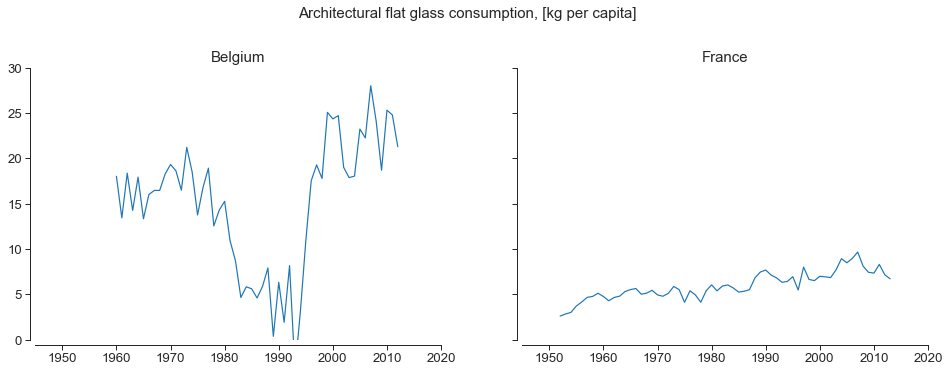

In [66]:
# Plot architectural glass consumption per capita:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(16, 5),
                         sharex=True, sharey=True)

for i, (ax, country) in enumerate(zip(axes.flatten(), countries)):
    ax.plot(be_fr.index,
            be_fr['Architectural glass consumption [kg/cap]'][country])

    ax.set_title(country)
    ax.set_xlim(1945, 2020)
    ax.set_ylim(0, 30)

fig.suptitle('Architectural flat glass consumption, [kg per capita]',
             fontsize=15, y=1.05)
sns.despine(offset=5)
plt.show()

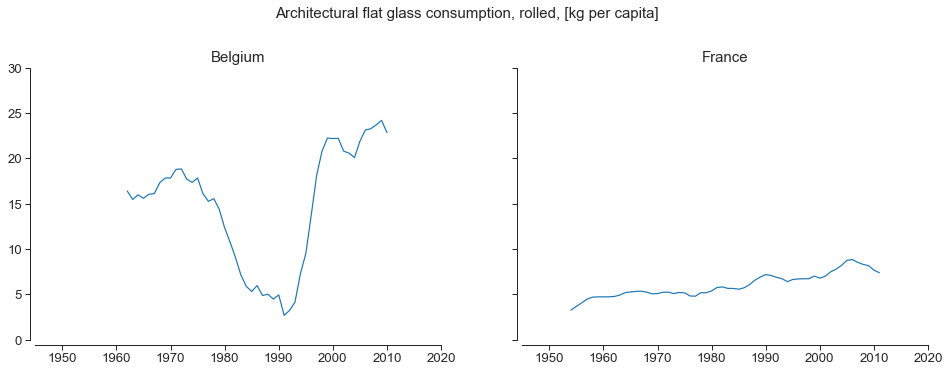

In [67]:
# Interpolation and moving average for architectural glass consuption / cap
# and plot:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(16, 5),
                         sharex=True, sharey=True)

for i, (ax, country) in enumerate(zip(axes.flatten(), countries)):
    ax.plot(be_fr.index,
            be_fr['Architectural glass consumption [kg/cap]'][country]
            .interpolate(method="linear", limit_area='inside')
            .rolling(5, center=True).mean())

    ax.set_title(country)
    ax.set_xlim(1945, 2020)
    ax.set_ylim(0, 30)

fig.suptitle('Architectural flat glass consumption, rolled, [kg per capita]',
             fontsize=15, y=1.05)
sns.despine(offset=5)
plt.show()

## Summary

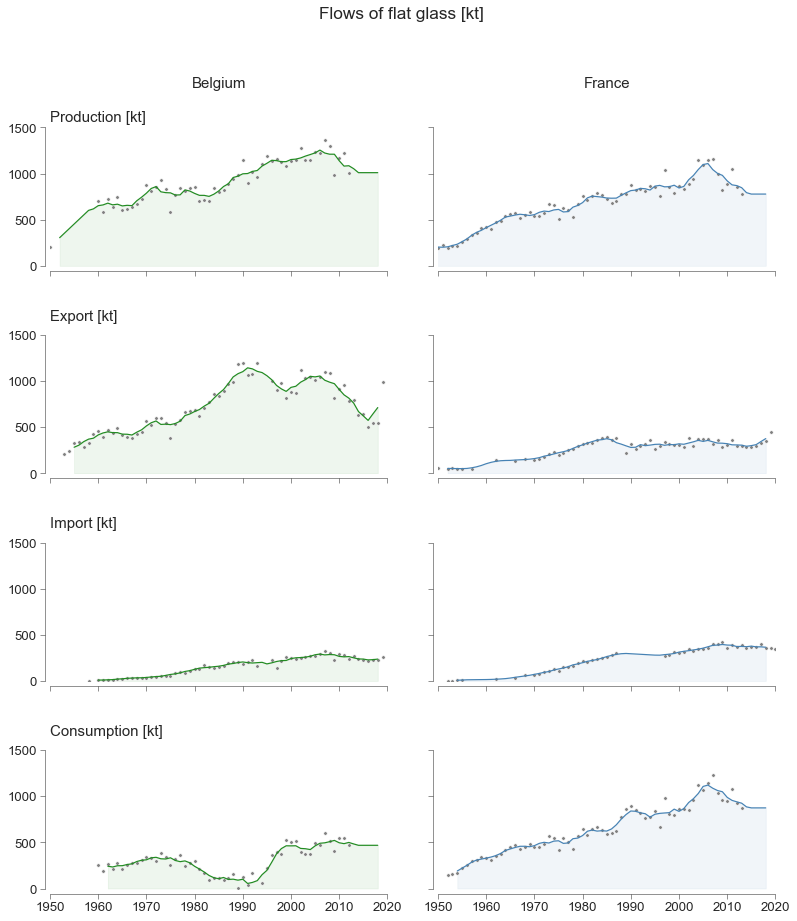

In [68]:
# Plot total import and export flows, moving average w/ a 5-y. window length:
toplot = ['Production', 'Export', 'Import', 'Consumption']
nrows = len(toplot)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(13, 14))

for row, data in enumerate(toplot):
    for col, country in enumerate(countries):
        ax = axes[row][col]
        # Define the color and title for the subplots:
        if country == 'Belgium':
            color = 'forestgreen'
            ax.set_title(f"{data} [kt]", loc='left', pad=15)
        else:
            color = 'steelblue'

        (be_fr[(f"{data} [kt]", country)]
         .interpolate(method='linear')
         .rolling(5, center=True).mean()
         .plot(ax=ax, c=color)
         )

        x = be_fr.index
        y = (be_fr[(f"{data} [kt]", country)]
             .interpolate(method='linear')
             .rolling(5, center=True).mean())
        ax.fill_between(x, y, color=color, alpha=0.075)

        sns.scatterplot(data=be_fr[f"{data} [kt]"][country],
                        marker='.', s=50, color='grey',
                        ax=ax)

        ax.get_legend().remove()

        ax.minorticks_off()
        ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
        style_ax(ax)
        ax.set_ylabel(None)

        ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

        if row == 0:
            ax.set_title(country, y=1.25)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 1500)
plt.xticks(np.arange(1950, 2021, 10))

fig.subplots_adjust(wspace=0.15, hspace=0.5)

fig.suptitle("Flows of flat glass [kt]", y=1)
sns.despine(offset=5)

if export:
    # Save image:
    fig.savefig(os.path.join(path_img, 'AppendixC_BEFR_FlatGlassFlows.png'),
                dpi=600, bbox_inches='tight')
    fig.savefig(os.path.join(path_img, 'AppendixC_BEFR_FlatGlassFlows.pdf'),
                bbox_inches='tight')

plt.show()

In [69]:
# Calculate annual growth:
for country in countries:
    be_fr[('Growth, flat glass [%]', country)] = (
        be_fr[('Production [kt]', country)].pct_change()
    )

    be_fr[('Growth, arch glass [%]', country)] = (
        be_fr[('Architectural glass production [kt]', country)].pct_change()
    )

    be_fr[('Growth, arch glass consumption [%]', country)] = (
        be_fr[('Architectural glass consumption [kt]', country)].pct_change()
    )

In [70]:
# Growth of the production in FR from 1950 to 1965:
A = be_fr[('Growth, flat glass [%]', 'France')].loc[1951:1965].mean()*100
B = be_fr[('Growth, arch glass [%]', 'France')].loc[1951:1965].mean()*100
print(f'Flat glass production growth in FR, 1950-1965:\n {A:.2f}%\n',
      f'Architectural glass production growth in FR, 1950-1965:\n {B:.2f}%')

# Growth of the production in FR from 1965 to 2000:
C = be_fr[('Growth, flat glass [%]', 'France')].loc[1966:2000].mean()*100
D = be_fr[('Growth, arch glass [%]', 'France')].loc[1966:2000].mean()*100
print(f'Flat glass production growth in FR, 1965-2000:\n {C:.2f}%\n ',
      f'Architectural glass production growth in FR, 1965-2000:\n {D:.2f}%')

# Growth of the consumption in FR from 1955 to 2000:
E = (be_fr[('Growth, arch glass consumption [%]', 'France')]
     .loc[1956:2000].mean()*100)
print(f'Architectural glass consumption growth in FR, 1955-2000:\n {E:.2f}%')

Flat glass production growth in FR, 1950-1965:
 7.90%
 Architectural glass production growth in FR, 1950-1965:
 5.69%
Flat glass production growth in FR, 1965-2000:
 1.89%
  Architectural glass production growth in FR, 1965-2000:
 1.34%
Architectural glass consumption growth in FR, 1955-2000:
 3.05%


In [71]:
# Growth of the production in BE from 1985 to 2005:
F = be_fr[('Growth, flat glass [%]', 'Belgium')].loc[1986:2005].mean()*100
G = be_fr[('Growth, arch glass [%]', 'Belgium')].loc[1986:2005].mean()*100
print(f'Flat glass production growth in BE, 1985-2005:\n {F:.2f}%\n ',
      f'Architectural glass production growth in BE, 1985-2005:\n {G:.2f}')

Flat glass production growth in BE, 1985-2005:
 2.57%
  Architectural glass production growth in BE, 1985-2005:
 2.62


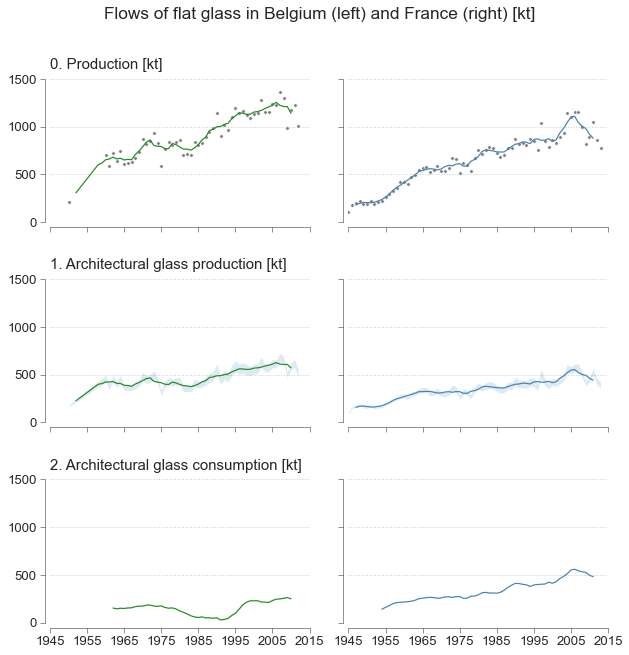

In [72]:
# Plot graphs to summarize main results:
toplot = ['Production',
          'Architectural glass production',
          'Architectural glass consumption']

nrows = len(toplot)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(10, 10))

for row, plot in enumerate(toplot):
    for col, country in enumerate(countries):
        ax = axes[row][col]
        # Define the color and title for the subplots:
        if country == 'Belgium':
            color = 'forestgreen'
            ax.set_title(f"{row}. {plot} [kt]", pad=10, loc='left')
            if plot == 'Architectural glass production':
                ax.fill_between(x, yminBE, ymaxBE, alpha=0.15)
        else:
            color = 'steelblue'
            if plot == 'Architectural glass production':
                ax.fill_between(x, yminFR, ymaxFR, alpha=0.15)

        # Plot the 5-year rolled data:
        (be_fr[(f"{plot} [kt]", country)]
         .interpolate(method="linear", limit_area='inside')
         .rolling(5, center=True).mean()
         .plot(ax=ax, c=color)
         )
        ax.minorticks_off()
        ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
        style_ax(ax)

        # Plot data gathered from literature review:
        if row == 0:
            sns.scatterplot(data=be_fr['Production [kt]'][country],
                            marker='.', s=50, color='grey',
                            ax=ax)
            ax.set_ylabel(None)
            ax.get_legend().remove()

ax.set_ylim(0, 1500)
ax.set_xlim(1945, 2015)

plt.xticks(np.arange(1945, 2016, 10))

fig.suptitle("Flows of flat glass in Belgium (left) and France (right) [kt]")
fig.subplots_adjust(wspace=0.15, hspace=0.4)

sns.despine(offset=5)
plt.show()

if export:
    # Save image:
    fig.savefig(os.path.join(path_img, 'Fig3_BE-FR_FlatGlassFlows.png'),
                dpi=600, bbox_inches='tight')
    fig.savefig(os.path.join(path_img, 'Fig3_BE-FR_FlatGlassFlows.pdf'),
                bbox_inches='tight')

# Material, Energy and Carbon Intensity in the Flat Glass Industry

## Material Intensity since 1945, France

In [73]:
# Creating a DataFrame for material intensity:
mat_intensity = fr_data.parse('RawMat_Intensity').set_index('year')

In [74]:
mat_intensity['cullet, kg/kg'] = (mat_intensity['internal cullet, kg/kg']
                                  + mat_intensity['external cullet, kg/kg'])

In [75]:
materials = ['sand', 'cullet', 'sodium carbonate',
             'limestone', 'dolomite', 'feldspar']

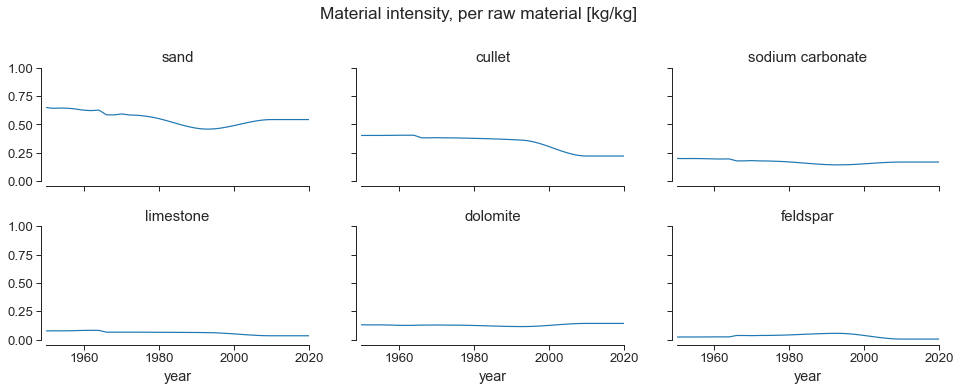

In [76]:
fig, axes = plt.subplots(nrows=2, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 5))

for i, (ax, mat) in enumerate(zip(axes.flatten(), materials)):
    ax.set_title(mat)
    (mat_intensity[f"{mat}, kg/kg"]
     .interpolate(method='pchip', limit_direction='forward')
     .plot(ax=ax)
     )

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 1)

fig.suptitle("Material intensity, per raw material [kg/kg]", y=1.05)
fig.subplots_adjust(hspace=0.4)

sns.despine(offset=5)
plt.show()

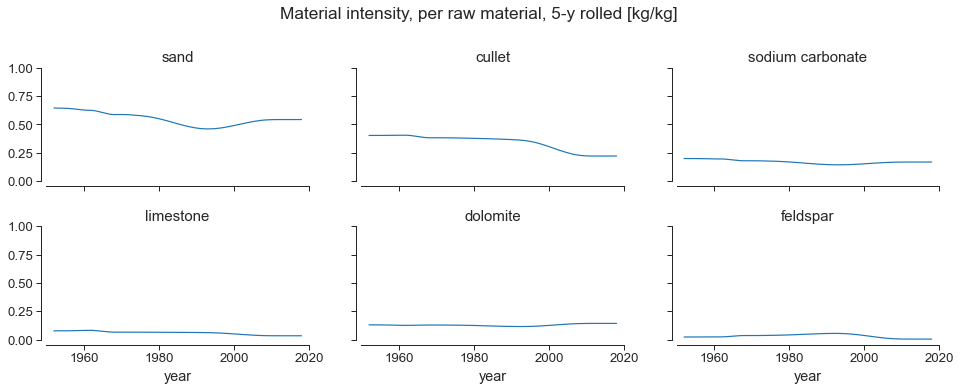

In [77]:
fig, axes = plt.subplots(nrows=2, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 5))

for i, (ax, mat) in enumerate(zip(axes.flatten(), materials)):
    ax.set_title(mat)
    (mat_intensity[f"{mat}, kg/kg"]
     .interpolate(method='pchip', limit_direction='forward')
     .rolling(5, center=True).mean()
     .plot(ax=ax))

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 1)

fig.suptitle("Material intensity, per raw material, 5-y rolled [kg/kg]",
             y=1.05)
fig.subplots_adjust(hspace=0.4)

sns.despine(offset=5)
plt.show()

In [78]:
# Estimate the material intensity (sum of the intenisities per material):
mat_intensity['Total raw materials, kg/kg'] = 0

for mat in materials:
    mat_intensity['Total raw materials, kg/kg'] = (
        mat_intensity[f"{mat}, kg/kg"]
        + mat_intensity['Total raw materials, kg/kg']
    )

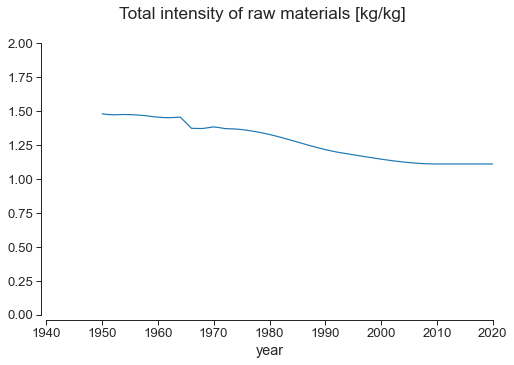

In [79]:
# Plot the material intensity:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=mat_intensity,
             x=mat_intensity.index,
             y=(mat_intensity['Total raw materials, kg/kg']
                .interpolate(method='pchip', limit_direction='forward')),
             ax=ax)

ax.yaxis.label.set_visible(False)
ax.set_xlim(1940, 2020)
ax.set_ylim(0, 2)

fig.suptitle("Total intensity of raw materials [kg/kg]")

sns.despine(offset=5)
plt.show()

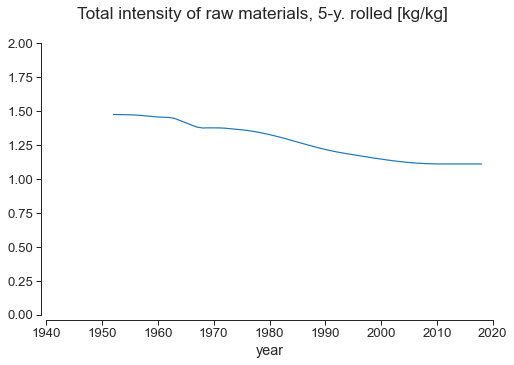

In [80]:
# Plot a 5-y rolled material intensity:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=mat_intensity,
             x=mat_intensity.index,
             y=(mat_intensity['Total raw materials, kg/kg']
                .interpolate(method='pchip', limit_direction='forward')
                 .rolling(5, center=True).mean()),
             ax=ax)

ax.yaxis.label.set_visible(False)
ax.set_xlim(1940, 2020)
ax.set_ylim(0, 2)

fig.suptitle("Total intensity of raw materials, 5-y. rolled [kg/kg]")

sns.despine(offset=5)
plt.show()

In [81]:
matwocullet = ['sand', 'sodium carbonate', 'limestone',
               'dolomite', 'feldspar']

In [82]:
# Estimate the material intensity without cullet:
mat_intensity['Total raw mat w/o cullet, kg/kg'] = 0

for mat in matwocullet:
    mat_intensity['Total raw mat w/o cullet, kg/kg'] = (
        mat_intensity[f"{mat}, kg/kg"]
        + mat_intensity['Total raw mat w/o cullet, kg/kg']
    )

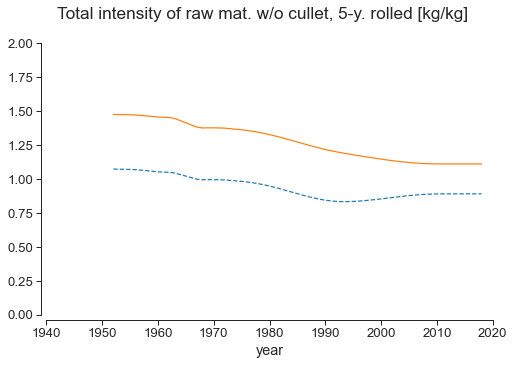

In [83]:
# Plot a 5-y rolled material intensity:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=mat_intensity,
             x=mat_intensity.index,
             y=(mat_intensity['Total raw mat w/o cullet, kg/kg']
                .interpolate(method='pchip', limit_direction='forward')
                 .rolling(5, center=True).mean()),
             ax=ax, linestyle='--')

sns.lineplot(data=mat_intensity,
             x=mat_intensity.index,
             y=(mat_intensity['Total raw materials, kg/kg']
                .interpolate(method='pchip', limit_direction='forward')
                 .rolling(5, center=True).mean()),
             ax=ax)

ax.yaxis.label.set_visible(False)
ax.set_xlim(1940, 2020)
ax.set_ylim(0, 2)

fig.suptitle("Total intensity of raw mat. w/o cullet, 5-y. rolled [kg/kg]")

sns.despine(offset=5)
plt.show()

## Energy Intensity since 1945, France and Belgium

In [84]:
# Create a DataFrame for the energy intensity in France:
fr_energy_intensity = fr_data.parse('Energy_Intensity').set_index('year')

be_energy_intensity = be_data.parse('Energy_Intensity').set_index('year')

In [85]:
# Create a unique DataFrame for FR and BE flat glass flows:
be_fr_energy_intensity = pd.concat(
    [fr_energy_intensity['fuel oil, GJ/t'],
     be_energy_intensity['fuel oil, GJ/t'],
     fr_energy_intensity['natural gas, GJ/t'],
     be_energy_intensity['natural gas, GJ/t'],
     fr_energy_intensity['electricity, GJ/t'],
     be_energy_intensity['electricity, GJ/t']],
    axis=1, keys=[('fuel oil, GJ/t', 'France'),
                  ('fuel oil, GJ/t', 'Belgium'),
                  ('natural gas, GJ/t', 'France'),
                  ('natural gas, GJ/t', 'Belgium'),
                  ('electricity, GJ/t', 'France'),
                  ('electricity, GJ/t', 'Belgium')],
    names=['Info', 'Country']
).stack(dropna=False)

be_fr_energy_intensity = be_fr_energy_intensity.unstack()

In [86]:
energies = ['fuel oil', 'natural gas', 'electricity']

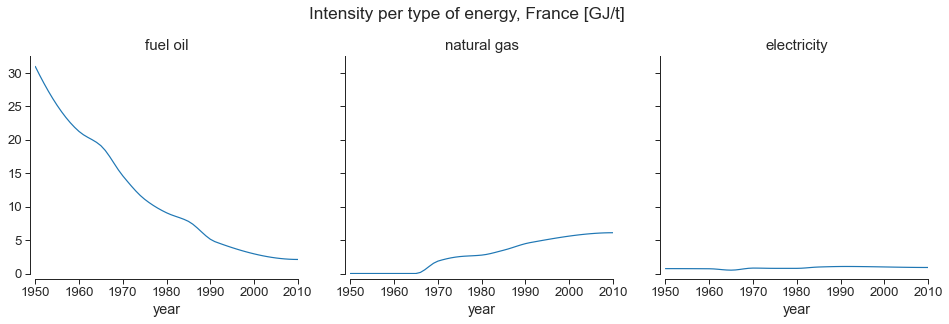

In [87]:
# Plot the intensity per type of energy, France:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 4))

for i, (ax, energy) in enumerate(zip(axes.flatten(), energies)):
    ax.set_title(energy)
    (be_fr_energy_intensity[(f"{energy}, GJ/t", "France")]  # Interpolate:
     .interpolate(method='pchip', limit_direction='forward')
     .plot(ax=ax))

ax.set_xlim(1950, 2010)
ax.set_ylim(ymin=0)

fig.suptitle("Intensity per type of energy, France [GJ/t]", y=1.05)

sns.despine(offset=5)
plt.show()

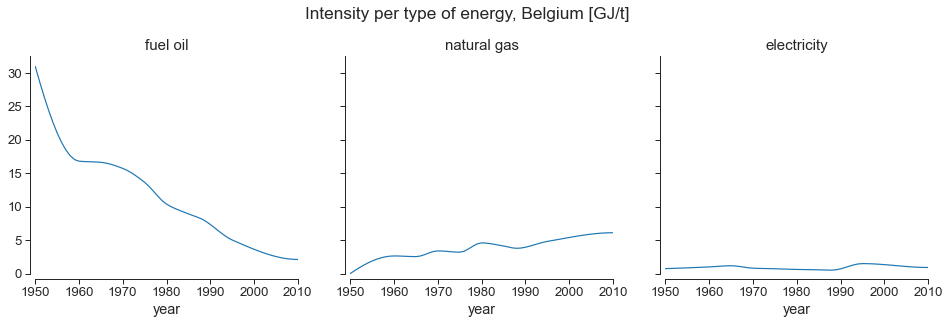

In [88]:
# Plot the intensity per type of energy, Belgium:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 4))

for i, (ax, energy) in enumerate(zip(axes.flatten(), energies)):
    ax.set_title(energy)
    (be_fr_energy_intensity[(f"{energy}, GJ/t", "Belgium")]  # Interpolate:
     .interpolate(method='pchip', limit_direction='forward')
     .plot(ax=ax))

ax.set_xlim(1950, 2010)
ax.set_ylim(ymin=0)

fig.suptitle("Intensity per type of energy, Belgium [GJ/t]", y=1.05)

sns.despine(offset=5)
plt.show()

In [89]:
# Estimate the total energy intensity
# (sum of the intensities per type of energy):
for country in countries:
    be_fr_energy_intensity[('Total energy, GJ/t', country)] = 0
    for energy in energies:
        be_fr_energy_intensity[('Total energy, GJ/t', country)] = (
            be_fr_energy_intensity[('Total energy, GJ/t', country)]
            + be_fr_energy_intensity[(f"{energy}, GJ/t", country)]
        )

In [90]:
fossilfuels = ['fuel oil', 'natural gas']

In [91]:
# Estimate the total energy intensity
# (without electricity)
for country in countries:
    be_fr_energy_intensity[('Total energy w/o elec., GJ/t', country)] = 0
    for energy in fossilfuels:
        be_fr_energy_intensity[('Total energy w/o elec., GJ/t', country)] = (
            be_fr_energy_intensity[('Total energy w/o elec., GJ/t', country)]
            + be_fr_energy_intensity[(f"{energy}, GJ/t", country)]
        )

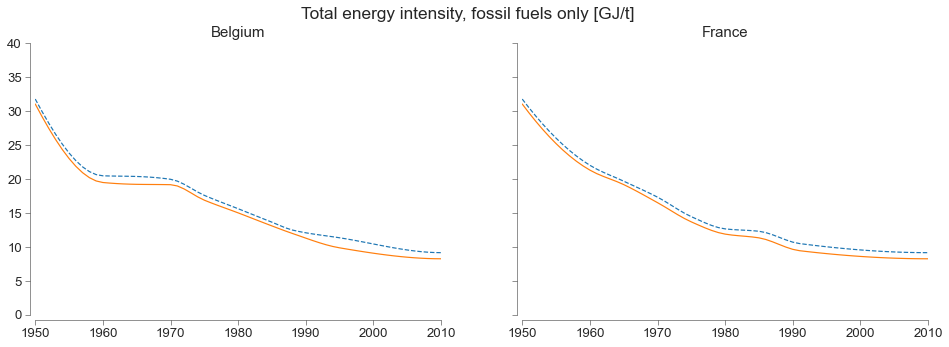

In [92]:
# Plot the total energy intensity:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         sharex=True, sharey=True,
                         figsize=(16, 5))

for i, (ax, country) in enumerate(zip(axes.flatten(), countries)):
    sns.lineplot(data=be_fr_energy_intensity,
                 x=be_fr_energy_intensity.index,
                 y=(be_fr_energy_intensity[('Total energy, GJ/t', country)]
                    .interpolate(method='pchip', limit_direction='forward')),
                 ax=ax, linestyle='--')

    sns.lineplot(data=be_fr_energy_intensity,
                 x=be_fr_energy_intensity.index,
                 y=(be_fr_energy_intensity[('Total energy w/o elec., GJ/t',
                                           country)]
                    .interpolate(method='pchip', limit_direction='forward')),
                 ax=ax)

    ax.set_xlim(1950, 2010)
    ax.set_ylim(0, 40)
    ax.set_title(country)
    ax.yaxis.label.set_visible(False)
    style_ax(ax)


fig.suptitle("Total energy intensity, fossil fuels only [GJ/t]")

sns.despine(offset=5)
plt.show()

In [93]:
# Estimate energy intensity according to ratios:
for energy in energies:
    for country in countries:
        be_fr_energy_intensity[(f"{energy}, %", country)] = (
            (be_fr_energy_intensity[(f"{energy}, GJ/t", country)]
             .interpolate(method='pchip', limit_direction='forward'))
            / (be_fr_energy_intensity[('Total energy, GJ/t', country)]
               .interpolate(method='pchip', limit_direction='forward'))
        )

In [94]:
be_fr_energy_intensity

Info    electricity, GJ/t        fuel oil, GJ/t        natural gas, GJ/t  \
Country           Belgium France        Belgium France           Belgium   
year                                                                       
1945                  NaN    NaN            NaN    NaN               NaN   
1946                  NaN    NaN            NaN    NaN               NaN   
1947                  NaN    NaN            NaN    NaN               NaN   
1948                  NaN    NaN            NaN    NaN               NaN   
1949                  NaN    NaN            NaN    NaN               NaN   
...                   ...    ...            ...    ...               ...   
2016                  NaN    NaN            NaN    NaN               NaN   
2017                  NaN    NaN            NaN    NaN               NaN   
2018                  NaN    NaN            NaN    NaN               NaN   
2019                  0.9    0.9            2.1    2.1               6.1   
2020                  NaN    NaN            NaN    NaN               NaN   

Info           Total energy, GJ/t        Total energy w/o elec., GJ/t         \
Country France            Belgium France                      Belgium France   
year                                                                           
1945       NaN                NaN    NaN                          NaN    NaN   
1946       NaN                NaN    NaN                          NaN    NaN   
1947       NaN                NaN    NaN                          NaN    NaN   
1948       NaN                NaN    NaN                          NaN    NaN   
1949       NaN                NaN    NaN                          NaN    NaN   
...        ...                ...    ...                          ...    ...   
2016       NaN                NaN    NaN                          NaN    NaN   
2017       NaN                NaN    NaN                          NaN    NaN   
2018       NaN                NaN    NaN                          NaN    NaN   
2019       6.1                9.1    9.1                          8.2    8.2   
2020       NaN                NaN    NaN                          NaN    NaN   

Info    fuel oil, %        natural gas, %        electricity, %         
Country     Belgium France        Belgium France        Belgium France  
year                                                                    
1945            NaN    NaN            NaN    NaN            NaN    NaN  
1946            NaN    NaN            NaN    NaN            NaN    NaN  
1947            NaN    NaN            NaN    NaN            NaN    NaN  
1948            NaN    NaN            NaN    NaN            NaN    NaN  
1949            NaN    NaN            NaN    NaN            NaN    NaN  
...             ...    ...            ...    ...            ...    ...  
2016           0.23   0.23           0.67   0.67            0.1    0.1  
2017           0.23   0.23           0.67   0.67            0.1    0.1  
2018           0.23   0.23           0.67   0.67            0.1    0.1  
2019           0.23   0.23           0.67   0.67            0.1    0.1  
2020           0.23   0.23           0.67   0.67            0.1    0.1  

[76 rows x 16 columns]

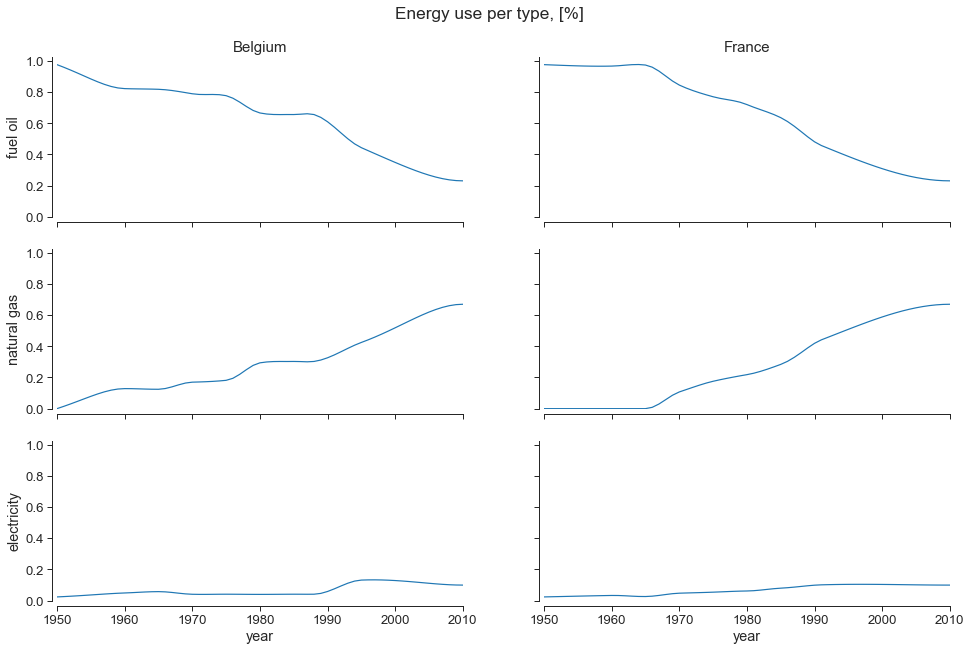

In [95]:
# Plot energy intensity per type of energy and in percent:
fig, axes = plt.subplots(nrows=3, ncols=2,
                         sharex=True, sharey=True,
                         figsize=(16, 10))

for row, energy in enumerate(energies):
    for col, country in enumerate(countries):
        ax = axes[row][col]
        be_fr_energy_intensity[(f"{energy}, %", country)].plot(ax=ax)

        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(energy)

ax.set_xlim(1950, 2010)
ax.set_ylim(ymin=0)

fig.suptitle("Energy use per type, [%]", y=0.95)

sns.despine(offset=5)
plt.show()

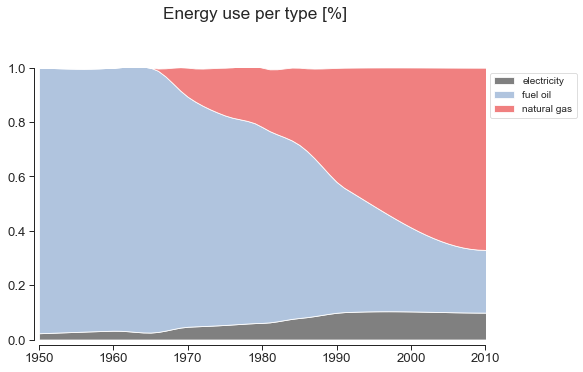

In [96]:
# Plot energy intensity per type of energy and in percent:
fig, ax = plt.subplots(figsize=(8, 5))

y = np.array([be_fr_energy_intensity[('electricity, %', 'France')].dropna(),
              be_fr_energy_intensity[('fuel oil, %', 'France')].dropna(),
              be_fr_energy_intensity[('natural gas, %', 'France')].dropna()])

x = range(1950, 2021)

plt.stackplot(x, y,
              labels=['electricity', 'fuel oil', 'natural gas'],
              colors=["grey", "lightsteelblue", "lightcoral"])
plt.legend(loc='upper left')

ax.set_xlim(1950, 2010)
ax.set_ylim(0, 1)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

fig.suptitle("Energy use per type [%]", y=1.05)

sns.despine(offset=5)
plt.show()

## Energy Intensity in the EU since 1970

In [97]:
# Create a DataFrame for the energy intensity in the EU:
eu_energy_intensity = eu_data.parse('Energy_Intensity').set_index('year')

In [98]:
energies = ['fuel oil', 'natural gas', 'electricity']

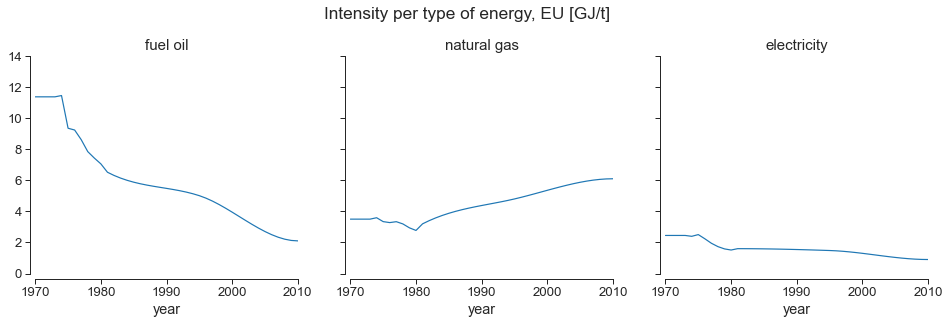

In [99]:
# Plot the intensity per type of energy:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 4))

for i, (ax, energy) in enumerate(zip(axes.flatten(), energies)):
    ax.set_title(energy)
    (eu_energy_intensity[f"{energy}, GJ/t"]  # Interpolate:
     .interpolate(method='pchip', limit_direction='forward')
     .plot(ax=ax))

ax.set_xlim(1970, 2010)
ax.set_ylim(0, 14)

fig.suptitle("Intensity per type of energy, EU [GJ/t]", y=1.05)

sns.despine(offset=5)
plt.show()

In [100]:
# Estimate the total energy intensity
# (sum of the intensities per type of energy)
# In Europe:
eu_energy_intensity['Total energy, GJ/t'] = 0

for energy in energies:
    eu_energy_intensity['Total energy, GJ/t'] = (
        eu_energy_intensity['Total energy, GJ/t']
        + eu_energy_intensity[f"{energy}, GJ/t"]
    )

In [101]:
fossilfuels = ['fuel oil', 'natural gas']

In [102]:
# Estimate the total energy intensity
# (without electricity)
eu_energy_intensity['Total energy w/o elec., GJ/t'] = 0

for energy in fossilfuels:
    eu_energy_intensity['Total energy w/o elec., GJ/t'] = (
        eu_energy_intensity['Total energy w/o elec., GJ/t']
        + eu_energy_intensity[f"{energy}, GJ/t"]
    )

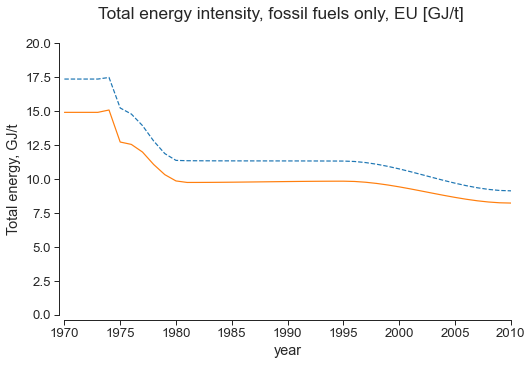

In [103]:
# Plot the total energy intensity:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=eu_energy_intensity,
             x=eu_energy_intensity.index,
             y=(eu_energy_intensity['Total energy, GJ/t']
                .interpolate(method='pchip', limit_direction='forward')),
             ax=ax, linestyle='--')

sns.lineplot(data=eu_energy_intensity,
             x=eu_energy_intensity.index,
             y=(eu_energy_intensity['Total energy w/o elec., GJ/t']
                .interpolate(method='pchip', limit_direction='forward')),
             ax=ax)

ax.set_xlim(1970, 2010)
ax.set_ylim(0, 20)

fig.suptitle("Total energy intensity, fossil fuels only, EU [GJ/t]")

sns.despine(offset=5)
plt.show()

In [104]:
# Estimate energy intensity according to ratios:
for energy in energies:
    eu_energy_intensity[f"{energy}, %"] = (
        (eu_energy_intensity[(f"{energy}, GJ/t")]
         .interpolate(method='pchip', limit_direction='forward'))
        / (eu_energy_intensity['Total energy, GJ/t']
           .interpolate(method='pchip', limit_direction='forward'))
    )

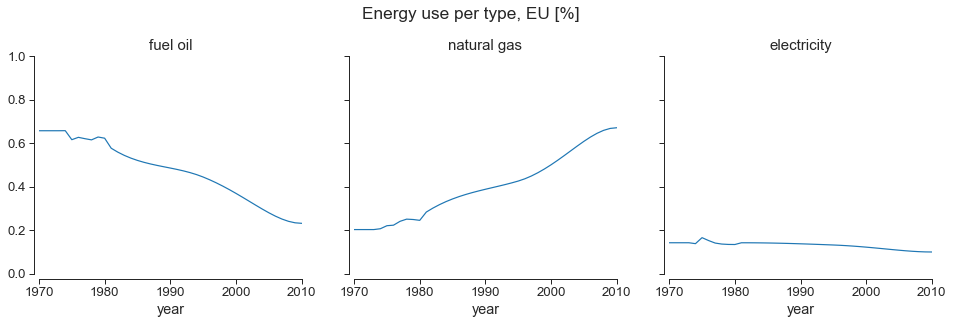

In [105]:
# Plot energy intensity per type of energy and in percent:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 4))

for i, (ax, energy) in enumerate(zip(axes.flatten(), energies)):
    ax.set_title(energy)
    eu_energy_intensity[f"{energy}, %"].plot(ax=ax)

ax.set_xlim(1970, 2010)
ax.set_ylim(0, 1)

fig.suptitle("Energy use per type, EU [%]", y=1.05)

sns.despine(offset=5)
plt.show()

## Carbon Intensity of the Flat Glass Manufacturing Process in France

In [106]:
# Create a DataFrame only with the CO2 emission data:
fr_emissions = fr_data.parse('emissions').set_index('year')

fr_co2_intensity = fr_emissions[['CO2 glass ind, kg/t']].copy()
fr_co2_intensity.rename(columns={'CO2 glass ind, kg/t': 'CO2 [kg/t]'},
                        inplace=True)

fr_co2_intensity.dropna()

,CO2 [kg/t]
year,
1947,2970.0
1950,2950.0
1960,2055.0
1965,1815.0
1970,1595.0
1975,1280.0
1980,1070.0
1985,950.0
1990,820.0


In [107]:
# Interpolate CO2 intensity accoring to a pchip method:
fr_co2_intensity['CO2 interpolated [kg/t]'] = (
    fr_co2_intensity['CO2 [kg/t]'].interpolate('pchip')
)

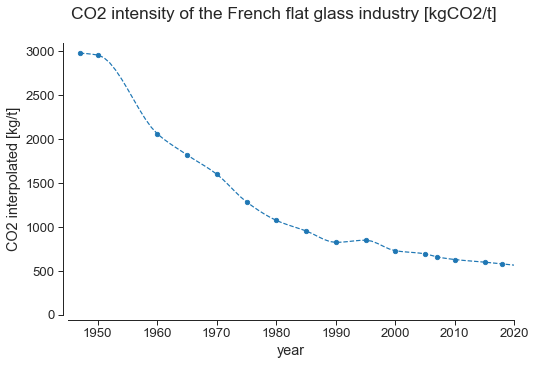

In [108]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=fr_co2_intensity['CO2 interpolated [kg/t]'])

ax.lines[0].set_linestyle("--")

ax.scatter(x=fr_co2_intensity.index, y=fr_co2_intensity['CO2 [kg/t]'],
           s=20)

ax.set_xlim(1945, 2020)
ax.set_ylim(ymin=0)
fig.suptitle("CO2 intensity of the French flat glass industry [kgCO2/t]")
sns.despine(offset=5)
plt.show()

## Carbon Intensity of the Flat Glass Manufacturing Process in the EU

In [109]:
# Create a DataFrame only with the CO2 emission data:
eu_emissions = eu_data.parse('emissions').set_index('year')

eu_co2_intensity = eu_emissions[['CO2 glass ind, kg/t']].copy()
eu_co2_intensity.rename(columns={'CO2 glass ind, kg/t': 'CO2 [kg/t]'},
                        inplace=True)

eu_co2_intensity.dropna()

,CO2 [kg/t]
year,
1970,1605.74
1975,1364.88
1980,1204.38
1985,1083.90
1990,1043.78
1991,1012.47
1992,986.35
1993,960.22
1994,929.03


In [110]:
# Interpolate CO2 intensity accoring to a pchip method:
eu_co2_intensity['CO2 interpolated [kg/t]'] = (
    eu_co2_intensity['CO2 [kg/t]'].interpolate('pchip')
)

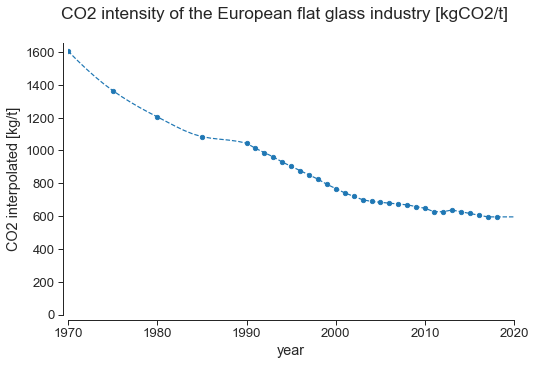

In [111]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=eu_co2_intensity['CO2 interpolated [kg/t]'])

ax.lines[0].set_linestyle("--")

ax.scatter(x=eu_co2_intensity.index, y=eu_co2_intensity['CO2 [kg/t]'],
           s=20)

ax.set_xlim(1970, 2020)
ax.set_ylim(ymin=0)
fig.suptitle("CO2 intensity of the European flat glass industry [kgCO2/t]")
sns.despine(offset=5)
plt.show()

## Summary

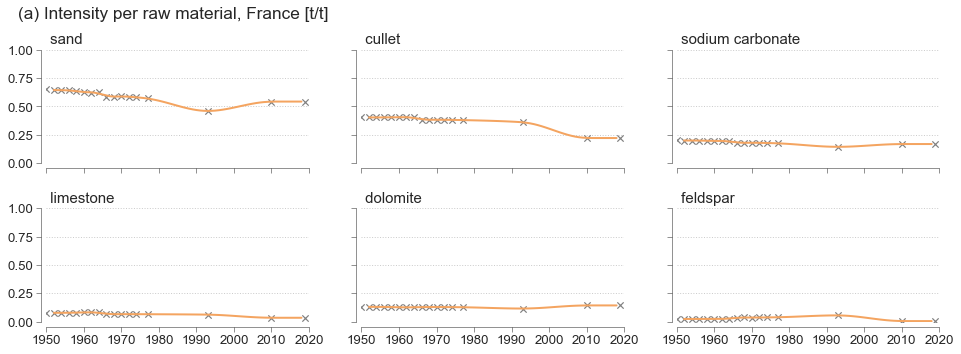

In [112]:
# Plot the material instensity per raw material:
fig, axes = plt.subplots(nrows=2, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 5))

for i, (ax, mat) in enumerate(zip(axes.flatten(), materials)):
    (mat_intensity[f"{mat}, kg/kg"]
     .interpolate(method='pchip', limit_direction='forward')
     .rolling(5, center=True).mean()
     .plot(ax=ax, c='sandybrown', linewidth=2))

    ax.scatter(x=mat_intensity.index, y=mat_intensity[f"{mat}, kg/kg"],
               s=40, marker='x', c='grey')
    plt.xticks(np.arange(1950, 2021, 10), rotation=45)

    ax.set_title(f" {mat}", loc='left')
    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
    style_ax(ax)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 1)

ax.minorticks_off()
plt.xticks(np.arange(1950, 2021, 10))

fig.suptitle(
    "(a) Intensity per raw material, France [t/t]", x=0.1, y=1, ha='left')

fig.subplots_adjust(wspace=0.2, hspace=0.4)

sns.despine(offset=5)

if export:
    # Save image:
    fig.savefig(os.path.join(path_img, 'Fig4_FR_Mat Intensity.png'),
                dpi=600, bbox_inches='tight')
    fig.savefig(os.path.join(path_img, 'Fig4_FR_Mat Intensity.pdf'),
                bbox_inches='tight')

plt.show()

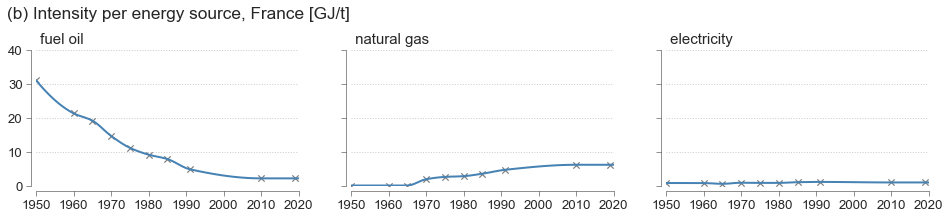

In [113]:
# Plot the energy intensity per source of energy, France:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 2.5)
                         )

for i, (ax, energy) in enumerate(zip(axes.flatten(), energies)):
    (be_fr_energy_intensity[(f"{energy}, GJ/t", "France")]
     .interpolate(method='pchip', limit_direction='forward')
     .plot(ax=ax, color='steelblue', linewidth=2))

    ax.scatter(x=be_fr_energy_intensity.index,
               y=be_fr_energy_intensity[(f"{energy}, GJ/t", "France")],
               s=40, marker='x', c='grey')

    ax.set_title(f" {energy}", loc='left')
    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
    style_ax(ax)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 40)

fig.suptitle("(b) Intensity per energy source, France [GJ/t]",
             x=0.1, y=1.12, ha='left')
fig.subplots_adjust(wspace=0.2)

ax.minorticks_off()
plt.xticks(np.arange(1950, 2021, 10))

sns.despine(offset=5)

if export:
    # Save image:
    fig.savefig(os.path.join(path_img, 'Fig4_FR_Energy Intensity.png'),
                dpi=600, bbox_inches='tight')
    fig.savefig(os.path.join(path_img, 'Fig4_FR_Energy Intensity.pdf'),
                bbox_inches='tight')

plt.show()

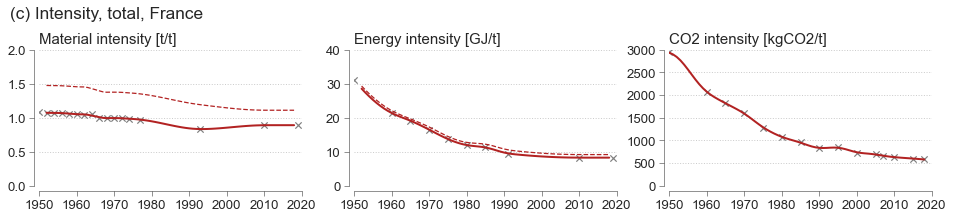

In [114]:
# Plot the intensity for energy, material and CO2 emissions:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True,
                         figsize=(16, 2.5))

# Material intensity
ax = axes[0]
(mat_intensity['Total raw materials, kg/kg']
 .interpolate(method='pchip', limit_direction='forward')
 .rolling(5, center=True).mean()
 .plot(ax=ax, c='firebrick', linestyle='--', linewidth=1.25)
 )

(mat_intensity['Total raw mat w/o cullet, kg/kg']
 .interpolate(method='pchip', limit_direction='forward')
 .rolling(5, center=True).mean()
 .plot(ax=ax, c='firebrick', linestyle='-', linewidth=2)
 )

ax.scatter(x=mat_intensity.index,
           y=mat_intensity['Total raw mat w/o cullet, kg/kg'],
           s=40, marker='x', c='grey')

ax.set_title("Material intensity [t/t]", loc='left')
ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
style_ax(ax)
ax.set_ylim(0, 2)
ax.set_xlim(1950, 2020)

# Energy intensity
ax = axes[1]
(be_fr_energy_intensity[('Total energy, GJ/t', 'France')]
 .interpolate(method='pchip', limit_direction='forward')
 .rolling(5, center=True).mean()
 .plot(ax=ax, c='firebrick', linestyle='--', linewidth=1.25))

(be_fr_energy_intensity[('Total energy w/o elec., GJ/t', 'France')]
 .interpolate(method='pchip', limit_direction='forward')
 .rolling(5, center=True).mean()
 .plot(ax=ax, c='firebrick', linewidth=2))

ax.scatter(x=be_fr_energy_intensity.index,
           y=be_fr_energy_intensity[(
               'Total energy w/o elec., GJ/t', 'France')],
           s=40, marker='x', c='grey')

ax.set_title("Energy intensity [GJ/t]", loc='left')
ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
style_ax(ax)
ax.set_ylim(0, 40)

# Carbon dioxide intensity
ax = axes[2]
(fr_co2_intensity['CO2 interpolated [kg/t]'].rolling(5, center=True).mean()
 .plot(ax=ax, c='firebrick', linewidth=2))

ax.scatter(x=fr_co2_intensity.index, y=fr_co2_intensity['CO2 [kg/t]'],
           s=40, marker='x', c='grey')

ax.set_title("CO2 intensity [kgCO2/t]", loc='left')
ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
style_ax(ax)
ax.set_ylim(0, 3000)

ax.minorticks_off()
plt.xticks(np.arange(1950, 2021, 10))
plt.yticks(np.arange(0, 3001, 500))

fig.suptitle("(c) Intensity, total, France", x=0.1, y=1.12, ha='left')
fig.subplots_adjust(wspace=0.20)

sns.despine(offset=5)

if export:
    # Save image:
    plt.savefig(os.path.join(path_img, 'Fig4_FR_TotalIntensity.png'),
                dpi=600, bbox_inches='tight')
    plt.savefig(os.path.join(path_img, 'Fig4_FR_TotalIntensity.pdf'),
                bbox_inches='tight')

plt.show()

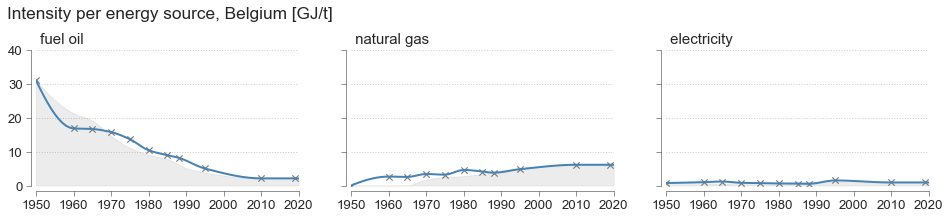

In [115]:
# Plot the energy intensity per source of energy, Belgium:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 2.5)
                         )

for i, (ax, energy) in enumerate(zip(axes.flatten(), energies)):
    (be_fr_energy_intensity[(f"{energy}, GJ/t", "Belgium")]
     .interpolate(method='pchip', limit_direction='forward')
     .plot(ax=ax, color='steelblue', linewidth=2))

    ax.scatter(x=be_fr_energy_intensity.index,
               y=be_fr_energy_intensity[(f"{energy}, GJ/t", "Belgium")],
               s=40, marker='x', c='grey')

    x = (be_fr_energy_intensity.reset_index()['year'])
    y = (be_fr_energy_intensity[(f"{energy}, GJ/t", "France")]
         .interpolate(method='pchip', limit_direction='forward'))
    ax.fill_between(x, y, color="grey", alpha=0.15)

    ax.set_title(f" {energy}", loc='left')
    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
    style_ax(ax)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 40)

fig.suptitle("Intensity per energy source, Belgium [GJ/t]",
             x=0.1, y=1.12, ha='left')
fig.subplots_adjust(wspace=0.2)

ax.minorticks_off()
plt.xticks(np.arange(1950, 2021, 10))

sns.despine(offset=5)

if export:
    # Save image:
    fig.savefig(os.path.join(path_img, 'Fig4_BE_Energy Intensity.png'),
                dpi=600, bbox_inches='tight')
    fig.savefig(os.path.join(path_img, 'Fig4_BE_Energy Intensity.pdf'),
                bbox_inches='tight')

plt.show()

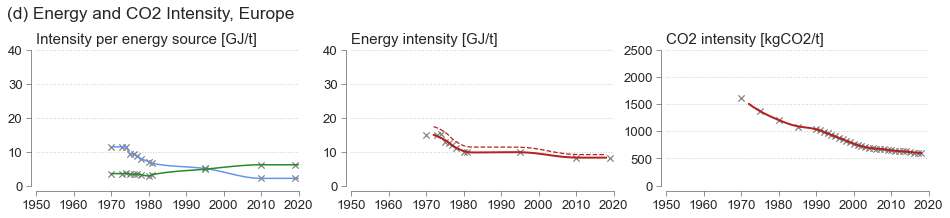

In [116]:
# Plot the intensity for energy, material and CO2 emissions:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True,
                         figsize=(16, 2.5))

# Intensity, per energy source
ax = axes[0]
(eu_energy_intensity["fuel oil, GJ/t"]
 .interpolate(method='pchip', limit_direction='forward')
 .plot(ax=ax, color='cornflowerblue', linestyle='-', linewidth=1.5))

ax.scatter(x=eu_energy_intensity.index,
           y=eu_energy_intensity["fuel oil, GJ/t"],
           s=40, marker='x', c='grey')

(eu_energy_intensity["natural gas, GJ/t"]
 .interpolate(method='pchip', limit_direction='forward')
 .plot(ax=ax, color='forestgreen', linewidth=1.5, linestyle='-'))

ax.scatter(x=eu_energy_intensity.index,
           y=eu_energy_intensity["natural gas, GJ/t"],
           s=40, marker='x', c='grey')

ax.set_title("Intensity per energy source [GJ/t]", loc='left')
ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
style_ax(ax)
ax.set_ylim(0, 40)
ax.set_xlim(1950, 2020)

# Energy intensity, total
ax = axes[1]
(eu_energy_intensity['Total energy, GJ/t']
 .interpolate(method='pchip', limit_direction='forward')
 .rolling(5, center=True).mean()
 .plot(ax=ax, c='firebrick', linestyle='--', linewidth=1.25))

(eu_energy_intensity['Total energy w/o elec., GJ/t']
 .interpolate(method='pchip', limit_direction='forward')
 .rolling(5, center=True).mean()
 .plot(ax=ax, c='firebrick', linewidth=2))

ax.scatter(x=eu_energy_intensity.index,
           y=eu_energy_intensity['Total energy w/o elec., GJ/t'],
           s=40, marker='x', c='grey')

ax.set_title("Energy intensity [GJ/t]", loc='left')
ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
style_ax(ax)
ax.set_ylim(0, 40)

# Carbon dioxide intensity
ax = axes[2]
(eu_co2_intensity['CO2 interpolated [kg/t]'].rolling(5, center=True).mean()
 .plot(ax=ax, c='firebrick', linewidth=2))

ax.scatter(x=eu_co2_intensity.index, y=eu_co2_intensity['CO2 [kg/t]'],
           s=40, marker='x', c='grey')

ax.set_title("CO2 intensity [kgCO2/t]", loc='left')
ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
style_ax(ax)
ax.set_ylim(0, 2500)

ax.minorticks_off()
plt.xticks(np.arange(1950, 2021, 10))

fig.suptitle("(d) Energy and CO2 Intensity, Europe", x=0.1, y=1.12, ha='left')
fig.subplots_adjust(wspace=0.20)

sns.despine(offset=5)

if export:
    # Save image:
    plt.savefig(os.path.join(path_img, 'Fig4_EU_Intensity.png'),
                dpi=600, bbox_inches='tight')
    plt.savefig(os.path.join(path_img, 'Fig4_EU_Intensity.pdf'),
                bbox_inches='tight')

plt.show()

# Raw Material and Energy Use and CO2 Emissions in the European Flat Glass Industry

## Use of Raw Materials in the Production of Flat Glass

In [117]:
# Absolute use of raw materials for fat glass production:
for mat in materials:
    eu_df[f"{mat}, flat glass [kt]"] = (
        eu_df['Production [kt]']
        * (mat_intensity[f"{mat}, kg/kg"]
           .interpolate(method='pchip', limit_direction='forward'))
    )

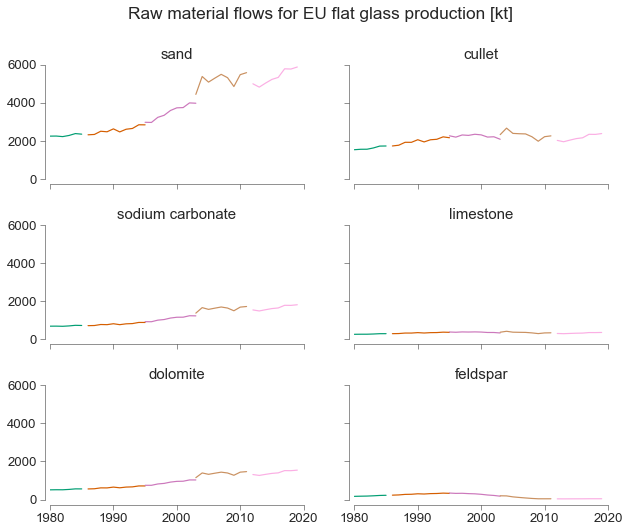

In [118]:
# Plot raw material flows for EU flat glass production
fig, axes = plt.subplots(nrows=3, ncols=2,
                         sharex=True, sharey=True,
                         figsize=(10, 8))

for i, (ax, material) in enumerate(zip(axes.flatten(), materials)):
    sns.lineplot(data=eu_df.reset_index(),
                 x='year', y=f"{material}, flat glass [kt]",
                 hue='Nbr of countries',
                 palette='colorblind',
                 ax=ax)
    ax.set_title(material)
    ax.set_ylabel(None)
    style_ax(ax)
    ax.get_legend().remove()

ax.set_xlim(1980, 2020)
ax.set_ylim(0, 6000)

fig.suptitle("Raw material flows for EU flat glass production [kt]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

In [119]:
# Estimate total use of raw materials (sum per material):
eu_df['Total raw materials, flat glass [Mt]'] = 0

for material in materials:
    eu_df['Total raw materials, flat glass [Mt]'] = (
        eu_df[f"{material}, flat glass [kt]"]/1000
        + eu_df['Total raw materials, flat glass [Mt]']
    )

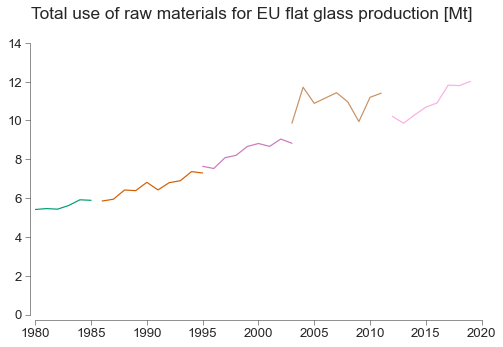

In [120]:
# Plot total material flows for EU flat glass production
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=eu_df.reset_index(),
             x='year', y='Total raw materials, flat glass [Mt]',
             hue='Nbr of countries',
             palette='colorblind',
             ax=ax)

ax.set_xlim(1980, 2020)
ax.set_ylabel(None)
style_ax(ax)
ax.set_ylim(0, 14)
ax.get_legend().remove()

fig.suptitle("Total use of raw materials for EU flat glass production [Mt]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

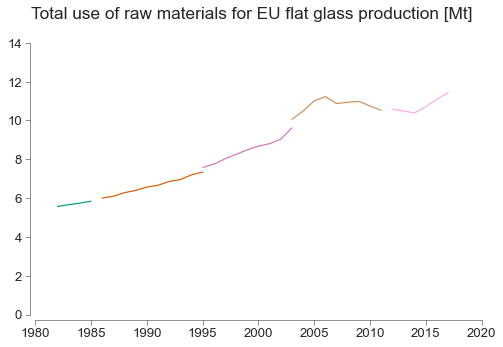

In [121]:
# Plot total material flows for EU flat glass production
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=eu_df.rolling(5, center=True).mean().reset_index(),
             x='year', y='Total raw materials, flat glass [Mt]',
             hue='Nbr of countries',
             palette='colorblind',
             ax=ax)

ax.set_xlim(1980, 2020)
ax.set_ylim(0, 14)
ax.get_legend().remove()
ax.set_ylabel(None)
style_ax(ax)

fig.suptitle("Total use of raw materials for EU flat glass production [Mt]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

## Energy Use in the Production of Flat Glass

In [122]:
# Absolute use of energy for flat glass production:
for energy in energies:
    eu_df[f"{energy}, flat glass [PJ]"] = (
        eu_df['Production [kt]']
        * (eu_energy_intensity[f"{energy}, GJ/t"]
           .interpolate(method='pchip', limit_direction='forward'))/1000
    )

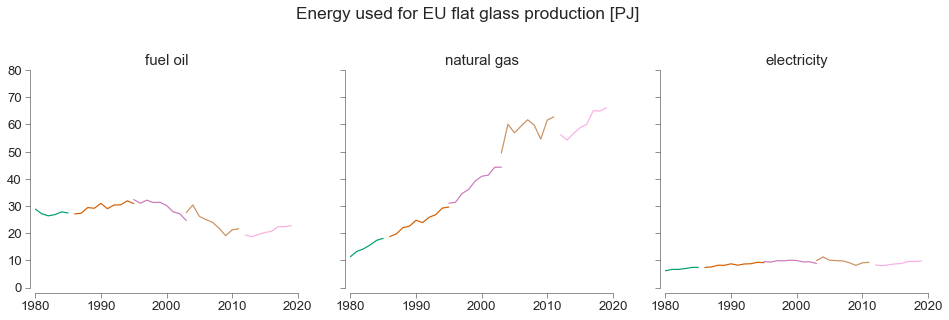

In [123]:
# Plot energy used for EU flat glass production
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 4))

for i, (ax, energy) in enumerate(zip(axes.flatten(), energies)):
    sns.lineplot(data=eu_df.reset_index(),
                 x='year', y=f"{energy}, flat glass [PJ]",
                 hue='Nbr of countries',
                 palette='colorblind',
                 ax=ax)

    ax.set_title(energy)
    ax.get_legend().remove()
    ax.set_ylabel(None)
    style_ax(ax)

ax.set_xlim(1980, 2020)
ax.set_ylim(0, 80)

fig.suptitle("Energy used for EU flat glass production [PJ]", y=1.1)
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

In [124]:
eu_df['Total energy, flat glass [PJ]'] = 0

for energy in energies:
    eu_df['Total energy, flat glass [PJ]'] = (
        eu_df[f"{energy}, flat glass [PJ]"]
        + eu_df['Total energy, flat glass [PJ]']
    )

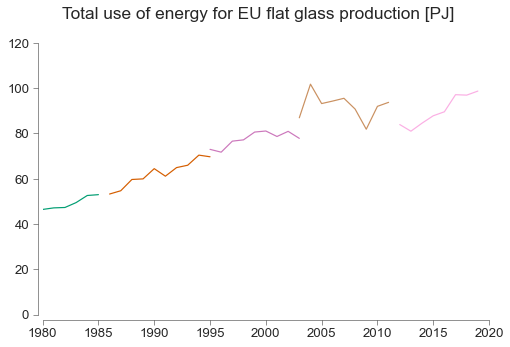

In [125]:
# Plot total energy use for EU flat glass production
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=eu_df.reset_index(),
             x='year', y='Total energy, flat glass [PJ]',
             hue='Nbr of countries',
             palette='colorblind',
             ax=ax)

ax.set_xlim(1980, 2020)
ax.set_ylim(0, 120)
ax.get_legend().remove()
ax.set_ylabel(None)
style_ax(ax)

fig.suptitle("Total use of energy for EU flat glass production [PJ]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

## Use of Raw Materials in the Production of Architectural Flat Glass

In [126]:
# Absolute use of raw materials for fat glass production:
for mat in materials:
    eu_df[f"{mat}, arch glass [kt]"] = (
        eu_df['Architectural glass production [kt]']
        * (mat_intensity[f"{mat}, kg/kg"]
           .interpolate(method='pchip', limit_direction='forward'))
    )

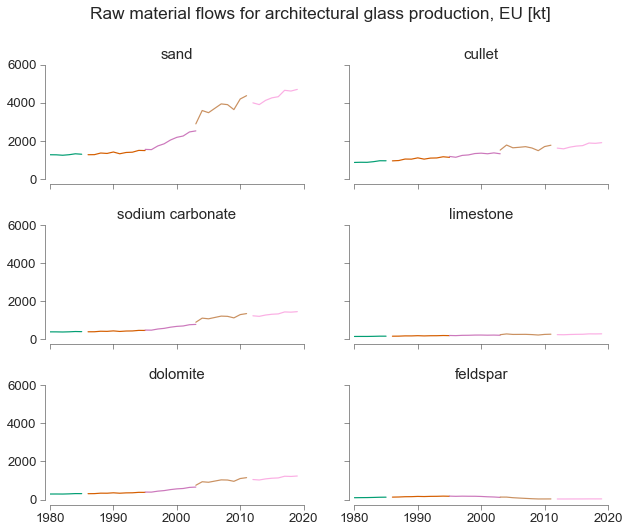

In [127]:
# Plot raw material flows for EU flat glass production
fig, axes = plt.subplots(nrows=3, ncols=2,
                         sharex=True, sharey=True,
                         figsize=(10, 8))

for i, (ax, material) in enumerate(zip(axes.flatten(), materials)):
    sns.lineplot(data=eu_df.reset_index(),
                 x='year', y=f"{material}, arch glass [kt]",
                 hue='Nbr of countries',
                 palette='colorblind',
                 ax=ax)

    ax.set_title(material)
    ax.set_xlim(1980, 2020)
    ax.set_ylim(0, 6000)
    ax.get_legend().remove()
    ax.set_ylabel(None)
    style_ax(ax)

fig.suptitle("Raw material flows for architectural glass production, EU [kt]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

In [128]:
eu_df['Total raw materials, arch glass [Mt]'] = 0

for material in materials:
    eu_df['Total raw materials, arch glass [Mt]'] = (
        eu_df[f"{material}, arch glass [kt]"]/1000
        + eu_df['Total raw materials, arch glass [Mt]']
    )

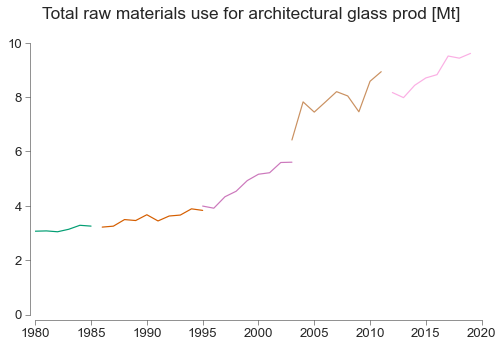

In [129]:
# Plot total material flows for EU architectural glass production
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=eu_df.reset_index(),
             x='year', y='Total raw materials, arch glass [Mt]',
             hue='Nbr of countries',
             palette='colorblind',
             ax=ax)

ax.set_xlim(1980, 2020)
ax.set_ylim(0, 10)
ax.get_legend().remove()
ax.set_ylabel(None)
style_ax(ax)

fig.suptitle("Total raw materials use for architectural glass prod [Mt]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

## Energy Use in the Production of Architectural Flat Glass

In [130]:
# Absolute use of energy for flat glass production:
for energy in energies:
    eu_df[f"{energy}, arch glass [PJ]"] = (
        eu_df['Architectural glass production [kt]']
        * (eu_energy_intensity[f"{energy}, GJ/t"]
           .interpolate(method='pchip', limit_direction='forward'))/1000
    )

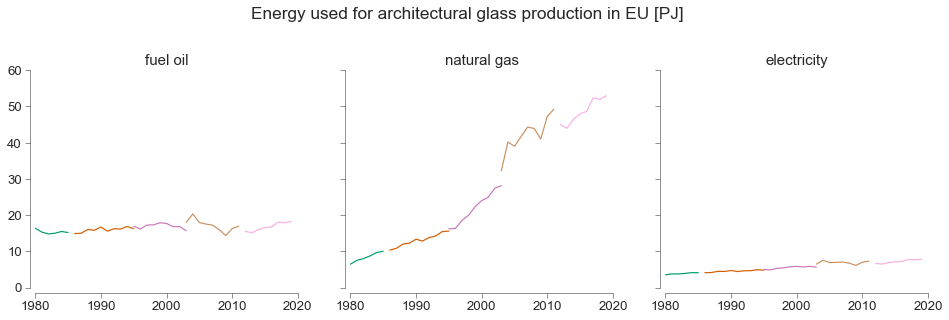

In [131]:
# Plot energy used for EU flat glass production
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 4))

for i, (ax, energy) in enumerate(zip(axes.flatten(), energies)):
    sns.lineplot(data=eu_df.reset_index(),
                 x='year', y=f"{energy}, arch glass [PJ]",
                 hue='Nbr of countries',
                 palette='colorblind',
                 ax=ax)

    ax.set_title(energy)
    ax.set_xlim(1980, 2020)
    ax.set_ylim(0, 60)
    ax.get_legend().remove()
    ax.set_ylabel(None)
    style_ax(ax)

fig.suptitle("Energy used for architectural glass production in EU [PJ]",
             y=1.1)
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

In [132]:
eu_df['Total energy, arch glass [PJ]'] = 0

for energy in energies:
    eu_df['Total energy, arch glass [PJ]'] = (
        eu_df[f"{energy}, arch glass [PJ]"]
        + eu_df['Total energy, arch glass [PJ]']
    )

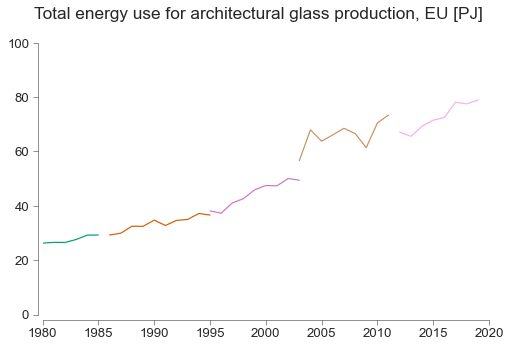

In [133]:
# Plot total energy use for EU flat glass production
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=eu_df.reset_index(),
             x='year', y='Total energy, arch glass [PJ]',
             hue='Nbr of countries',
             palette='colorblind',
             ax=ax)

ax.set_xlim(1980, 2020)
ax.set_ylim(0, 100)
ax.get_legend().remove()
ax.set_ylabel(None)
style_ax(ax)

fig.suptitle("Total energy use for architectural glass production, EU [PJ]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

## Absolute CO2 Emissions, Europe

In [134]:
# Estimate the CO2 emission related to flat glass production:
eu_df['CO2, flat glass [kt]'] = (
    eu_df['Production [kt]']
    * eu_co2_intensity['CO2 interpolated [kg/t]'] / 1000
)

In [135]:
# Estimate the CO2 emission related to architectural flat glass production:
eu_df['CO2, architectural glass [kt]'] = (
    eu_df['Architectural glass production [kt]']
    * eu_co2_intensity['CO2 interpolated [kg/t]'] / 1000
)

In [136]:
CO2_G = ['CO2, flat glass [kt]', 'CO2, architectural glass [kt]']

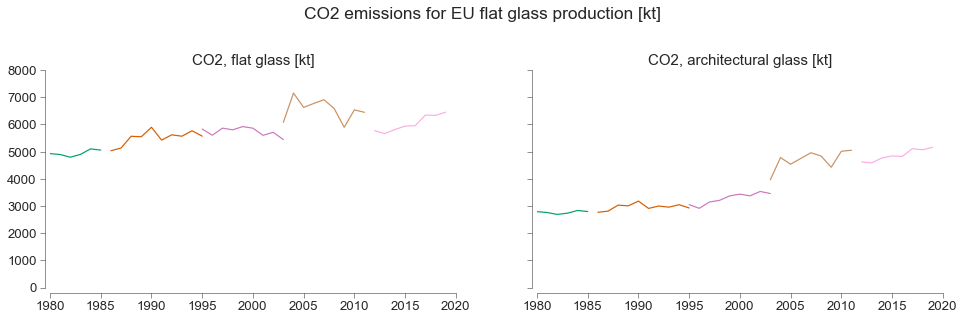

In [137]:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         sharex=True, sharey=True,
                         figsize=(16, 4))

for i, (ax, CO2) in enumerate(zip(axes.flatten(), CO2_G)):
    sns.lineplot(data=eu_df.reset_index(),
                 x='year', y=f"{CO2}",
                 hue='Nbr of countries',
                 palette='colorblind',
                 ax=ax)
    ax.set_title(CO2)
    ax.set_xlim(1980, 2020)
    ax.set_ylim(0, 8000)
    ax.get_legend().remove()
    ax.set_ylabel(None)
    style_ax(ax)

fig.suptitle("CO2 emissions for EU flat glass production [kt]", y=1.1)
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

## Summary

In [138]:
# Number of countries for trend curves:
EU_COUNTRIES = [(10, 15), (27, 28)]

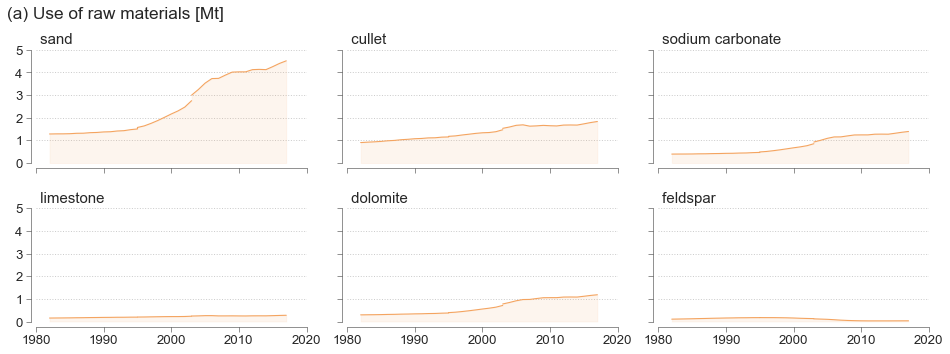

In [139]:
# Plot the absolute use of raw materials in EU for architectural glass prod:
fig, axes = plt.subplots(nrows=2, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 5))

for i, (ax, mat) in enumerate(zip(axes.flatten(), materials)):
    for a, b in EU_COUNTRIES:
        ax.plot(eu_df.interpolate().rolling(5, center=True).mean().loc[a:b]
                .reset_index(level='Nbr of countries')
                .sort_values(by=['year'])
                [f"{mat}, arch glass [kt]"],
                linewidth=1.1, c='sandybrown', linestyle='-')

    x = (eu_df.reset_index()['year'])
    y = (eu_df[f"{mat}, arch glass [kt]"].interpolate()
         .rolling(5, center=True).mean())

    ax.fill_between(x, y, color="sandybrown", alpha=0.1)
    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

    ax.set_title(f" {mat}", loc='left')
    style_ax(ax)

ax.set_ylim(0, 5000)
ax.set_xlim(1980, 2020)
plt.yticks(np.arange(0, 5001, 1000))

# Divide by 1000 the y-axis, results in Mt
ax.yaxis.set_major_formatter(y_1000)

fig.suptitle("(a) Use of raw materials [Mt]", x=0.1, y=1, ha='left')
fig.subplots_adjust(wspace=0.15, hspace=0.4)

sns.despine(offset=5)

if export:
    # Save image:
    fig.savefig(os.path.join(path_img, 'Fig5_EU_Use of raw materials.png'),
                dpi=600, bbox_inches='tight')
    fig.savefig(os.path.join(path_img, 'Fig5_EU_Use of raw materials.pdf'),
                bbox_inches='tight')

plt.show()

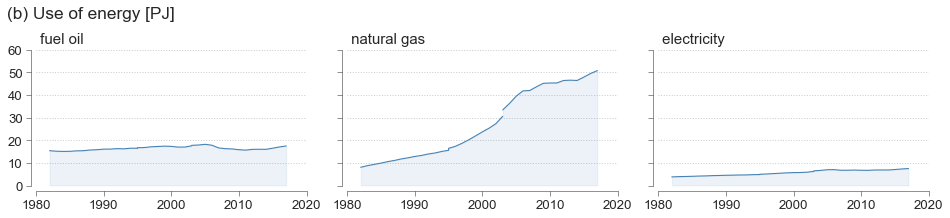

In [140]:
# Plot the absolute use of energy in the EU for architectural glass prod:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 2.5))

for i, (ax, energy) in enumerate(zip(axes.flatten(), energies)):
    for a, b in EU_COUNTRIES:
        ax.plot(eu_df.interpolate().rolling(5, center=True).mean().loc[a:b]
                .reset_index(level='Nbr of countries')
                .sort_values(by=['year'])
                [f"{energy}, arch glass [PJ]"],
                linewidth=1.1, c='steelblue', linestyle='-')

    x = (eu_df.reset_index()['year'])
    y = (eu_df[f"{energy}, arch glass [PJ]"].interpolate()
         .rolling(5, center=True).mean())
    ax.fill_between(x, y, color="steelblue", alpha=0.10)
    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

    ax.set_title(f" {energy}", loc='left')
    style_ax(ax)

ax.set_xlim(1980, 2020)
ax.set_ylim(0, 60)
plt.yticks(np.arange(0, 61, 10))

fig.suptitle("(b) Use of energy [PJ]", x=0.1, y=1.12, ha='left')
fig.subplots_adjust(wspace=0.15)

sns.despine(offset=5)

if export:
    # Save image:
    fig.savefig(os.path.join(path_img, 'Fig5_EU_Use of energy.png'),
                dpi=600, bbox_inches='tight')
    fig.savefig(os.path.join(path_img, 'Fig5_EU_Use of energy.pdf'),
                bbox_inches='tight')

plt.show()

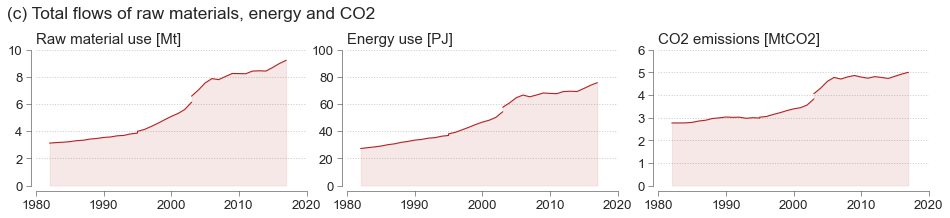

In [141]:
# Plot the total energy and material use, and total CO2 emissions:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True,
                         figsize=(16, 2.5))

# Total use of raw materials:
ax = axes[0]
for a, b in EU_COUNTRIES:
    ax.plot(eu_df.interpolate().rolling(5, center=True).mean().loc[a:b]
            .reset_index(level='Nbr of countries')
            .sort_values(by=['year'])
            ['Total raw materials, arch glass [Mt]'],
            linewidth=1.1, c='firebrick', linestyle='-')

x = (eu_df.reset_index()['year'])
y = (eu_df['Total raw materials, arch glass [Mt]'].interpolate()
     .rolling(5, center=True).mean())
ax.fill_between(x, y, color="firebrick", alpha=0.1)

ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

ax.set_title("Raw material use [Mt]", loc='left')
style_ax(ax)
ax.set_ylim(0, 10)
ax.set_xlim(1980, 2020)

# Total use of energy:
ax = axes[1]
for a, b in EU_COUNTRIES:
    ax.plot(eu_df.interpolate().rolling(5, center=True).mean().loc[a:b]
            .reset_index(level='Nbr of countries')
            .sort_values(by=['year'])
            ['Total energy, arch glass [PJ]'],
            linewidth=1.1, c='firebrick', linestyle='-')

x = (eu_df.reset_index()['year'])
y = (eu_df['Total energy, arch glass [PJ]'].interpolate()
     .rolling(5, center=True).mean())
ax.fill_between(x, y, color="firebrick", alpha=0.1)

ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

ax.set_title("Energy use [PJ]", loc='left')
style_ax(ax)
ax.set_ylim(0, 100)

# Total emissions of CO2:
ax = axes[2]
for a, b in EU_COUNTRIES:
    ax.plot(eu_df.interpolate().rolling(5, center=True).mean().loc[a:b]
            .reset_index(level='Nbr of countries')
            .sort_values(by=['year'])
            ['CO2, architectural glass [kt]'],
            linewidth=1.1, c='firebrick', linestyle='-')

x = (eu_df.reset_index()['year'])
y = (eu_df['CO2, architectural glass [kt]'].interpolate()
     .rolling(5, center=True).mean())
ax.fill_between(x, y, color="firebrick", alpha=0.1)

ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

# Divide by 1000 the y-axis, results in Mt
ax.yaxis.set_major_formatter(y_1000)

ax.set_title("CO2 emissions [MtCO2]", loc='left')
style_ax(ax)
ax.set_ylim(0, 6000)
plt.yticks(np.arange(0, 6001, 1000))

fig.suptitle("(c) Total flows of raw materials, energy and CO2",
             x=0.1, y=1.12, ha='left')
fig.subplots_adjust(wspace=0.15)

sns.despine(offset=5)

if export:
    # Save image:
    plt.savefig(os.path.join(path_img, 'Fig5_EU_Total flows.png'),
                dpi=600, bbox_inches='tight')
    plt.savefig(os.path.join(path_img, 'Fig5_EU_Total flows.pdf'),
                bbox_inches='tight')

plt.show()

# Raw Material and Energy Use and CO2 Emissions in the Belgian and French Flat Glass Industries

## Use of Raw Materials in the Production of Flat Glass

In [142]:
# Absolute use of raw materials for fat glass production:
for mat in materials:
    for country in countries:
        be_fr[(f"{mat}, flat glass [kt]", country)] = (
            be_fr[('Production [kt]', country)]
            * (mat_intensity[f"{mat}, kg/kg"]
               .interpolate(method='pchip', limit_direction='forward'))
        )

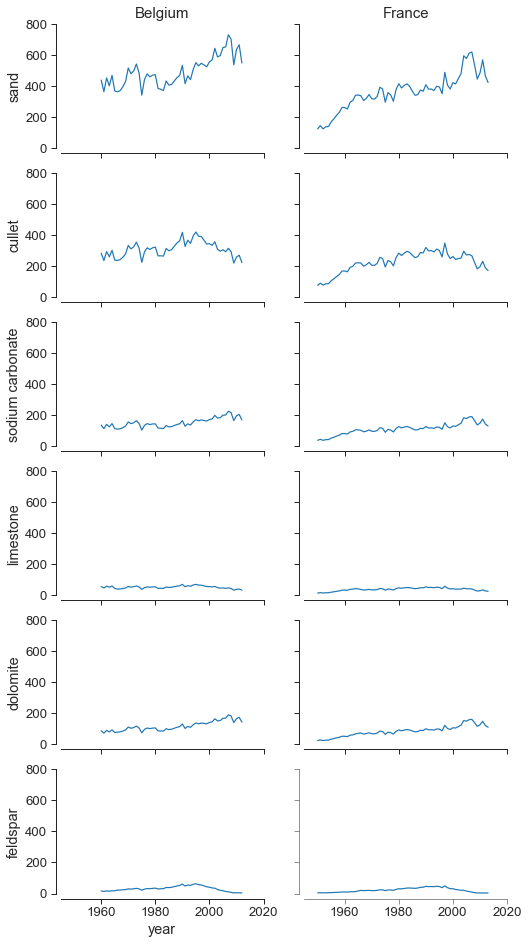

In [143]:
nrows = len(materials)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(8, 16))

for row, material in enumerate(materials):
    for col, country in enumerate(countries):
        ax = axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(material)
        be_fr[(f"{material}, flat glass [kt]", country)].plot(ax=ax)

ax.set_ylim(0, 800)
ax.set_xlim(1945, 2020)

style_ax(ax)

sns.despine(offset=5)
plt.show()

In [144]:
for country in countries:
    be_fr[('Total raw material use, flat glass [kt]', country)] = 0

for material in materials:
    be_fr['Total raw material use, flat glass [kt]'] = (
        (be_fr[f"{material}, flat glass [kt]"])
        + be_fr['Total raw material use, flat glass [kt]']
    )

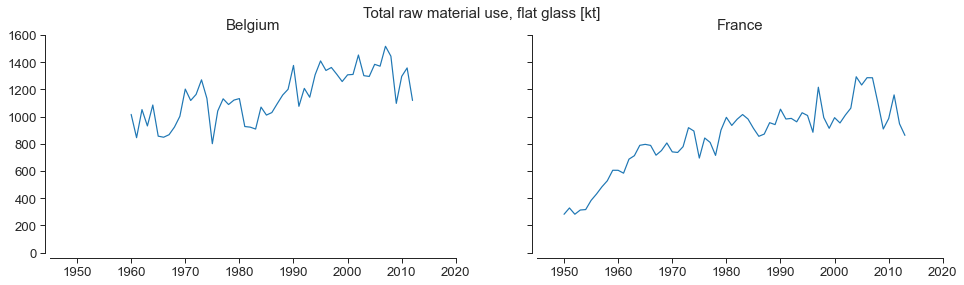

In [145]:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(16, 4),
                         sharex=True, sharey=True)

for i, (ax, country) in enumerate(zip(axes.flatten(), countries)):
    ax.plot(be_fr.index,
            be_fr['Total raw material use, flat glass [kt]'][country])

    ax.set_title(country)
    ax.set_xlim(1945, 2020)
    ax.set_ylim(0, 1600)

fig.suptitle('Total raw material use, flat glass [kt]', fontsize=15)
sns.despine(offset=5)
plt.show()

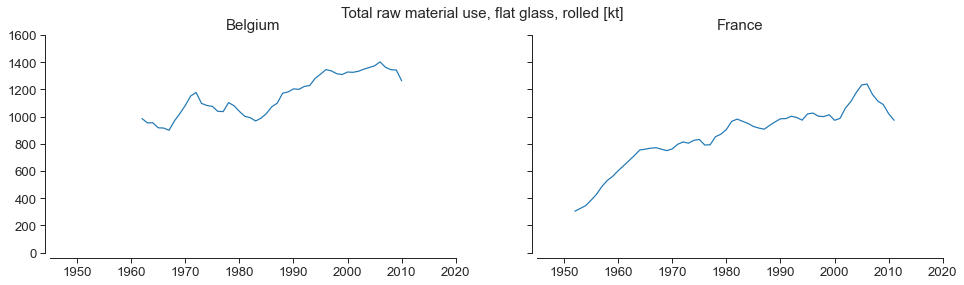

In [146]:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(16, 4),
                         sharex=True, sharey=True)

for i, (ax, country) in enumerate(zip(axes.flatten(), countries)):
    ax.plot(be_fr.index,
            be_fr['Total raw material use, flat glass [kt]'][country]
            .rolling(5, center=True).mean())

    ax.set_title(country)
    ax.set_xlim(1945, 2020)
    ax.set_ylim(0, 1600)

fig.suptitle('Total raw material use, flat glass, rolled [kt]', fontsize=15)
sns.despine(offset=5)
plt.show()

## Energy Use in the Production of Flat Glass

In [147]:
# Absolute use of energy for flat glass production:
for energy in energies:
    for country in countries:
        be_fr[(f"{energy}, flat glass [TJ]", country)] = (
            be_fr[('Production [kt]', country)]
            * (be_fr_energy_intensity[(f"{energy}, GJ/t", country)]
               .interpolate(method='pchip', limit_direction='forward'))
        )

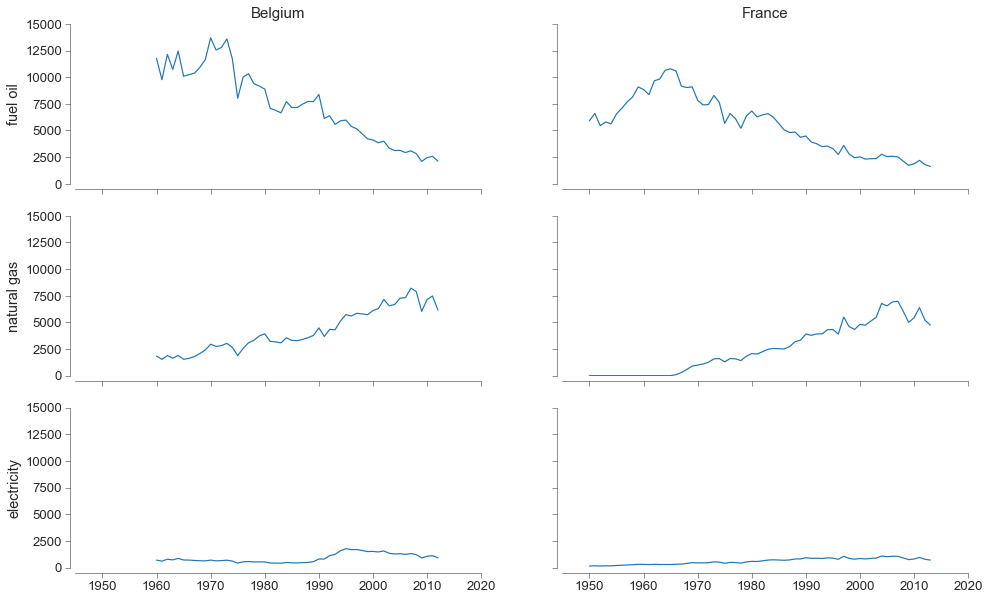

In [148]:
nrows = len(energies)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(16, 10))

for row, energy in enumerate(energies):
    for col, country in enumerate(countries):
        ax = axes[row][col]
        be_fr[(f"{energy}, flat glass [TJ]", country)].plot(ax=ax)

        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(energy)

        style_ax(ax)

ax.set_xlim(1945, 2020)
ax.set_ylim(0, 15000)

sns.despine(offset=5)
plt.show()

In [149]:
for country in countries:
    be_fr[('Total energy use, flat glass [TJ]', country)] = 0

for energy in energies:
    be_fr['Total energy use, flat glass [TJ]'] = (
        be_fr[f"{energy}, flat glass [TJ]"]
        + be_fr['Total energy use, flat glass [TJ]']
    )

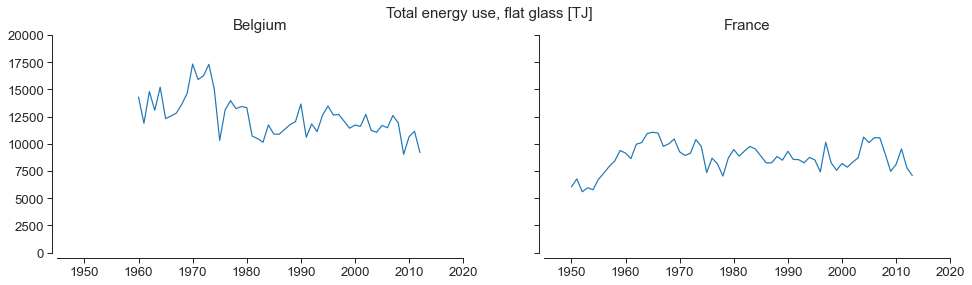

In [150]:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(16, 4),
                         sharex=True, sharey=True)

for i, (ax, country) in enumerate(zip(axes.flatten(), countries)):
    ax.plot(be_fr.index,
            be_fr['Total energy use, flat glass [TJ]'][country])
    ax.set_title(country)
    ax.set_xlim(1945, 2020)
    ax.set_ylim(0, 20000)

fig.suptitle('Total energy use, flat glass [TJ]', fontsize=15)
sns.despine(offset=5)
plt.show()

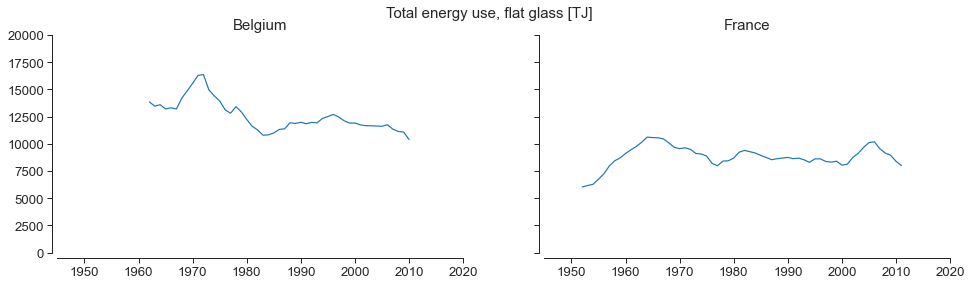

In [151]:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(16, 4),
                         sharex=True, sharey=True)

for i, (ax, country) in enumerate(zip(axes.flatten(), countries)):
    ax.plot(be_fr.index,
            be_fr['Total energy use, flat glass [TJ]'][country]
            .rolling(5, center=True).mean())
    ax.set_title(country)
    ax.set_xlim(1945, 2020)
    ax.set_ylim(0, 20000)

fig.suptitle('Total energy use, flat glass [TJ]', fontsize=15)
sns.despine(offset=5)
plt.show()

## Use of Raw Materials in the Production of Architectural Glass

In [152]:
# Absolute use of raw materials for architectural flat glass production:
for mat in materials:
    for country in countries:
        be_fr[(f"{mat}, architectural glass [kt]", country)] = (
            be_fr[('Architectural glass production [kt]', country)]
            * (mat_intensity[f"{mat}, kg/kg"]
               .interpolate(method='pchip', limit_direction='forward'))
        )

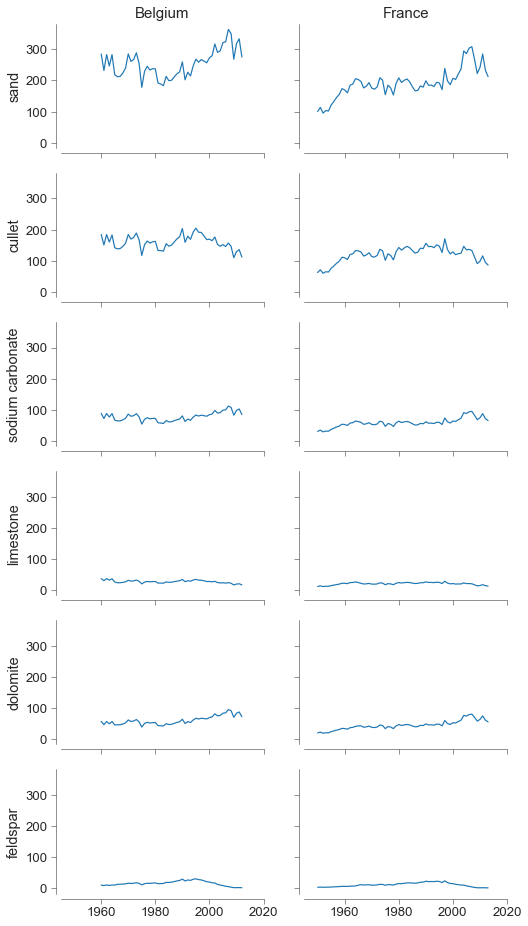

In [153]:
nrows = len(materials)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(8, 16))

for row, material in enumerate(materials):
    for col, country in enumerate(countries):
        ax = axes[row][col]
        be_fr[(f"{material}, architectural glass [kt]", country)].plot(ax=ax)

        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(material)

        style_ax(ax)

ax.set_xlim(1945, 2020)

sns.despine(offset=5)
plt.show()

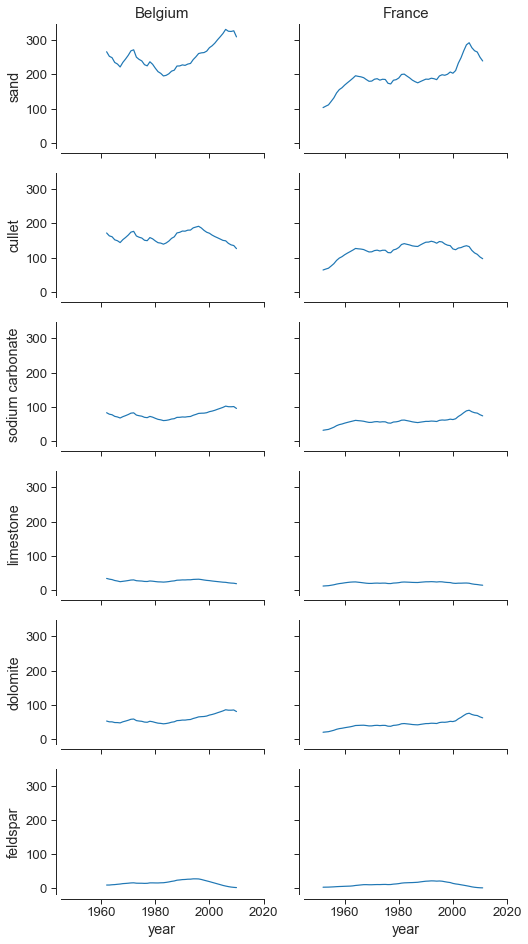

In [154]:
nrows = len(materials)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(8, 16))

for row, material in enumerate(materials):
    for col, country in enumerate(countries):
        ax = axes[row][col]
        (be_fr[(f"{material}, architectural glass [kt]", country)]
         .rolling(5, center=True).mean()
         .plot(ax=ax))

        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(material)

ax.set_xlim(1945, 2020)

sns.despine(offset=5)
plt.show()

In [155]:
for country in countries:
    be_fr[('Total raw material use, architectural glass [kt]', country)] = 0

for material in materials:
    be_fr['Total raw material use, architectural glass [kt]'] = (
        be_fr[f"{material}, architectural glass [kt]"]
        + be_fr['Total raw material use, architectural glass [kt]']
    )

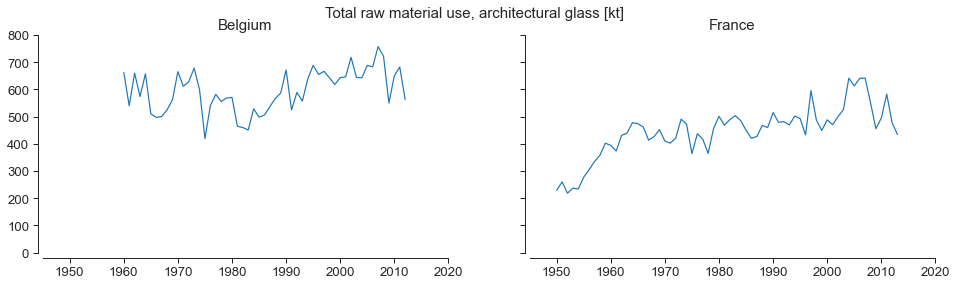

In [156]:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(16, 4),
                         sharex=True, sharey=True)

for i, (ax, country) in enumerate(zip(axes.flatten(), countries)):
    ax.plot(be_fr.index,
            be_fr['Total raw material use, architectural glass [kt]']
            [country])
    ax.set_title(country)
    ax.set_xlim(1945, 2020)
    ax.set_ylim(0, 800)

fig.suptitle('Total raw material use, architectural glass [kt]', fontsize=15)
sns.despine(offset=5)
plt.show()

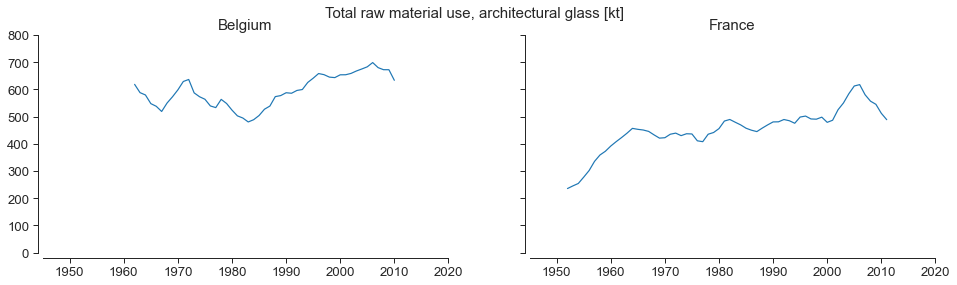

In [157]:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(16, 4),
                         sharex=True, sharey=True)

for i, (ax, country) in enumerate(zip(axes.flatten(), countries)):
    ax.plot(be_fr.index,
            be_fr['Total raw material use, architectural glass [kt]']
            [country].rolling(5, center=True).mean())
    ax.set_title(country)
    ax.set_xlim(1945, 2020)
    ax.set_ylim(0, 800)

fig.suptitle('Total raw material use, architectural glass [kt]', fontsize=15)
sns.despine(offset=5)
plt.show()

In [158]:
(be_fr['Total raw material use, architectural glass [kt]']['France']
 .rolling(5, center=True).mean())[2006]

617.6551457030012

## Energy Use in the Production of Architectural Glass

In [159]:
# Absolute use of energy for flat glass production:
for energy in energies:
    for country in countries:
        be_fr[(f"{energy}, architectural glass [TJ]", country)] = (
            be_fr[('Architectural glass production [kt]', country)]
            * (be_fr_energy_intensity[(f"{energy}, GJ/t", country)]
               .interpolate(method='pchip', limit_direction='forward'))
        )

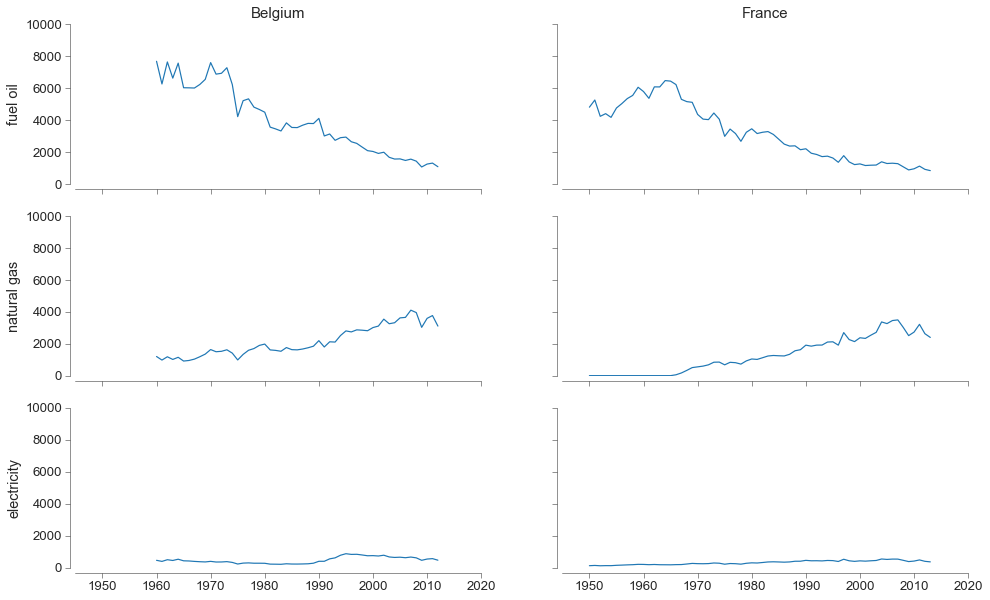

In [160]:
nrows = len(energies)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(16, 10))

for row, energy in enumerate(energies):
    for col, country in enumerate(countries):
        ax = axes[row][col]
        be_fr[(f"{energy}, architectural glass [TJ]", country)].plot(ax=ax)

        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(energy)

        style_ax(ax)

ax.set_xlim(1945, 2020)
ax.set_ylim(0, 10000)

sns.despine(offset=5)
plt.show()

In [161]:
for country in countries:
    be_fr[('Total energy use, architectural glass [TJ]', country)] = 0

for energy in energies:
    be_fr['Total energy use, architectural glass [TJ]'] = (
        be_fr[f"{energy}, architectural glass [TJ]"]
        + be_fr['Total energy use, architectural glass [TJ]']
    )

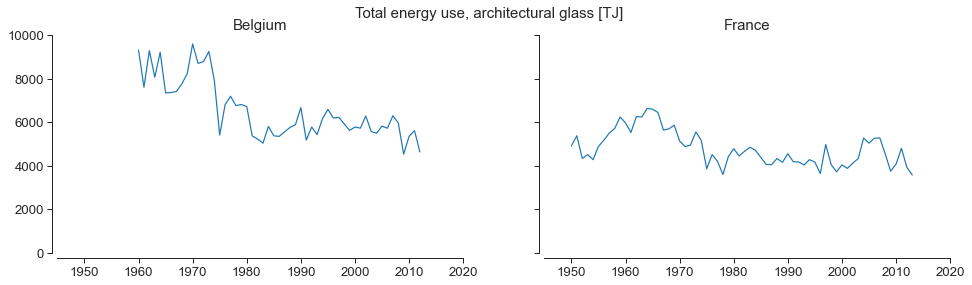

In [162]:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(16, 4),
                         sharex=True, sharey=True)

for i, (ax, country) in enumerate(zip(axes.flatten(), countries)):
    ax.plot(be_fr.index,
            be_fr['Total energy use, architectural glass [TJ]']
            [country])
    ax.set_title(country)
    ax.set_xlim(1945, 2020)
    ax.set_ylim(0, 10000)

fig.suptitle('Total energy use, architectural glass [TJ]', fontsize=15)
sns.despine(offset=5)
plt.show()

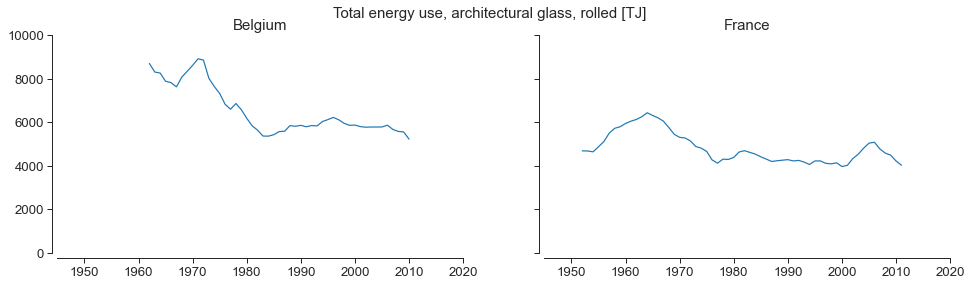

In [163]:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(16, 4),
                         sharex=True, sharey=True)

for i, (ax, country) in enumerate(zip(axes.flatten(), countries)):
    ax.plot(be_fr.index,
            be_fr['Total energy use, architectural glass [TJ]']
            [country].rolling(5, center=True).mean())
    ax.set_title(country)
    ax.set_xlim(1945, 2020)
    ax.set_ylim(0, 10000)

fig.suptitle('Total energy use, architectural glass, rolled [TJ]',
             fontsize=15)
sns.despine(offset=5)
plt.show()

## Absolute CO2 Emissions in Belgium and France since 1945


In [164]:
# Estimate the CO2 emission related to flat glass production:
for country in countries:
    be_fr[('CO2, flat glass [kt]', country)] = (
        be_fr[('Production [kt]', country)]
        * fr_co2_intensity['CO2 interpolated [kg/t]'] / 1000
    )

In [165]:
# Estimate the CO2 emission related to architectural flat glass production:
for country in countries:
    be_fr[('CO2, architectural glass [kt]', country)] = (
        be_fr[('Architectural glass production [kt]', country)]
        * fr_co2_intensity['CO2 interpolated [kg/t]'] / 1000
    )

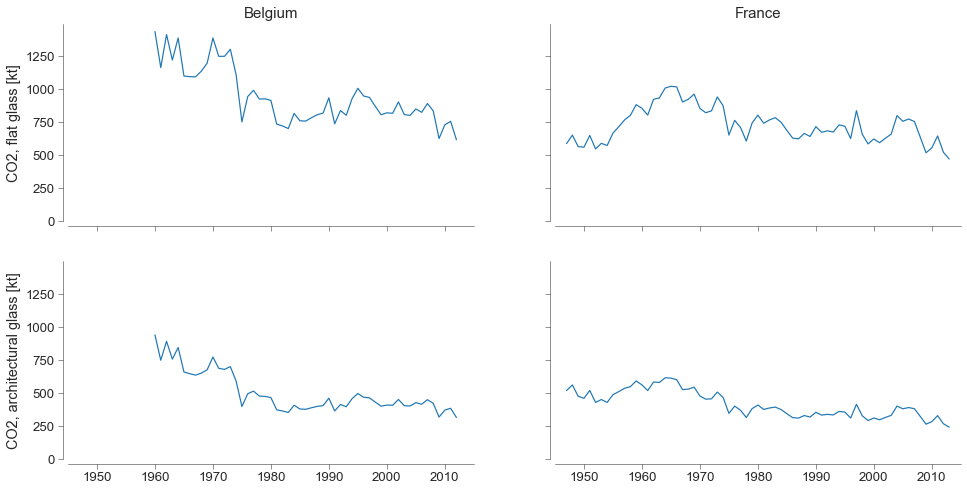

In [166]:
nrows = len(CO2_G)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(16, 8))

for row, CO2 in enumerate(CO2_G):
    for col, country in enumerate(countries):
        ax = axes[row][col]
        be_fr[(f"{CO2}", country)].plot(ax=ax)
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(CO2)

        style_ax(ax)

ax.set_xlim(1945, 2015)
ax.set_ylim(ymin=0)

sns.despine(offset=5)
plt.show()

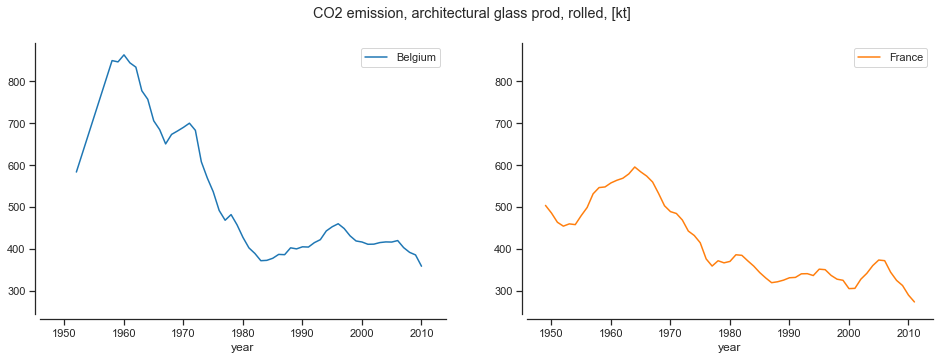

In [167]:
# 5-y. rolling of the CO2 emission related to architectural glass prod
# and plot:
with sns.plotting_context("notebook"):
    # Rolling flat glass production according to a 5-year mean
    (be_fr['CO2, architectural glass [kt]']
     .interpolate(method="linear", limit_area='inside')
     .rolling(5, center=True)
     .mean()).plot(subplots=True,
                   grid=False,
                   layout=(1, 2),
                   figsize=(16, 5),
                   sharex=True, sharey=True,
                   title=(
                       "CO2 emission, architectural glass prod, rolled, [kt]")
                   )

    ax.set_xlim(1945, 2015)
    ax.set_ylim(ymin=0)
    sns.despine(offset=5)
    plt.show()

## Summary

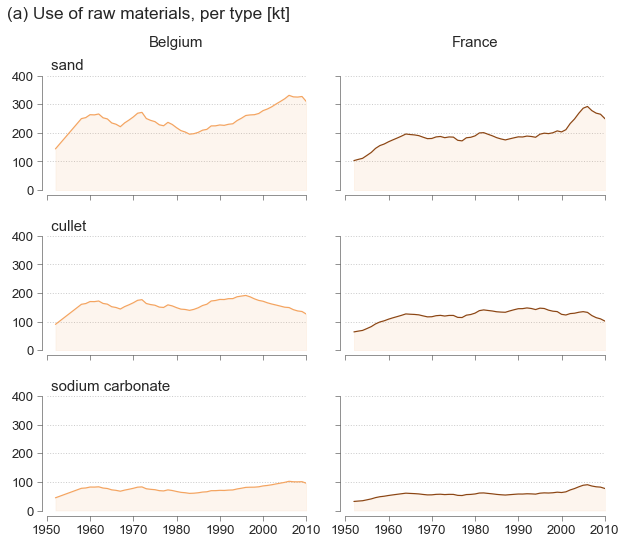

In [168]:
# Raw materials, per type:
mat_reduced = ['sand', 'cullet', 'sodium carbonate']

nrows = len(mat_reduced)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(10, 8))

for row, material in enumerate(mat_reduced):
    for col, country in enumerate(countries):
        ax = axes[row][col]
        if country == 'Belgium':
            color = 'sandybrown'
            ax.set_title(f" {material}", loc='left')
        else:
            color = 'saddlebrown'

        (be_fr[(f"{material}, architectural glass [kt]", country)]
         .interpolate(method="linear", limit_area='inside')
         .rolling(5, center=True).mean()
         .plot(ax=ax, c=color))

        x = be_fr.index
        y = (be_fr[(f"{material}, architectural glass [kt]", country)]
             .interpolate(method="linear", limit_area='inside')
             .rolling(5, center=True).mean())
        ax.fill_between(x, y, color="sandybrown", alpha=0.1)

        ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
        style_ax(ax)
        if row == 0:
            ax.set_title(country, y=1.2)

ax.set_xlim(1950, 2010)
ax.set_ylim(0, 400)
plt.xticks(np.arange(1950, 2011, 10))

fig.suptitle("(a) Use of raw materials, per type [kt]",
             x=0.07, y=1, ha='left')
fig.subplots_adjust(wspace=0.15, hspace=0.4)

sns.despine(offset=5)
plt.show()

if export:
    # Save image:
    fig.savefig(os.path.join(path_img, 'AppendixD_BEFR_Use of raw materials.png'),
                dpi=600, bbox_inches='tight')
    fig.savefig(os.path.join(path_img, 'AppendixD_BEFR_Use of raw materials.pdf'),
                bbox_inches='tight')

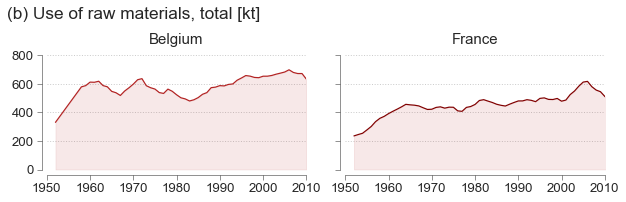

In [169]:
# Raw materials, total:
ncols = len(countries)

fig, axes = plt.subplots(nrows=1, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(10, 2.1))

for col, country in enumerate(countries):
    ax = axes[col]
    if country == 'Belgium':
        color = 'firebrick'
    else:
        color = 'maroon'

    (be_fr[("Total raw material use, architectural glass [kt]", country)]
     .interpolate(method="linear", limit_area='inside')
     .rolling(5, center=True).mean()
     .plot(ax=ax, c=color))

    x = be_fr.index
    y = (be_fr[("Total raw material use, architectural glass [kt]", country)]
         .interpolate(method="linear", limit_area='inside')
         .rolling(5, center=True).mean())
    ax.fill_between(x, y, color="firebrick", alpha=0.1)

    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
    style_ax(ax)
    ax.set_title(country, y=1.05)

ax.set_xlim(1950, 2010)
plt.xticks(np.arange(1950, 2011, 10))

ax.set_ylim(0, 800)

fig.suptitle("(b) Use of raw materials, total [kt]",
             x=0.07, y=1.2, ha='left')
fig.subplots_adjust(wspace=0.15, hspace=0.4)

sns.despine(offset=5)
plt.show()

if export:
    # Save image:
    fig.savefig(os.path.join(path_img, 'AppendixD_BEFR_Total raw materials.png'),
                dpi=600, bbox_inches='tight')
    fig.savefig(os.path.join(path_img, 'AppendixD_BEFR_Total raw materials.pdf'),
                bbox_inches='tight')

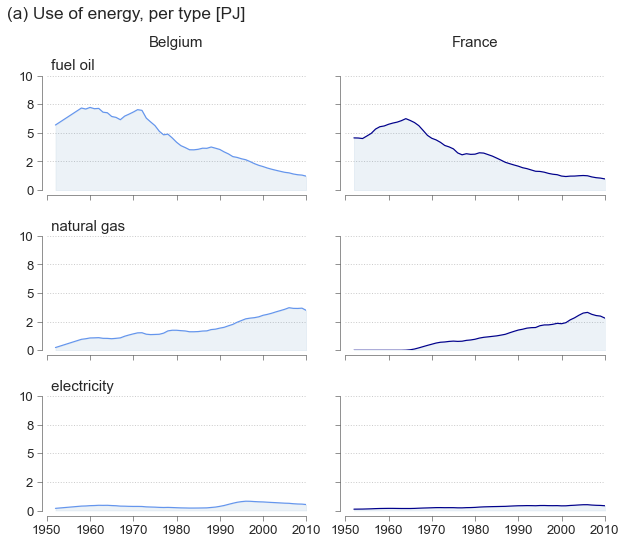

In [196]:
# Energy use, per type:
nrows = len(energies)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(10, 8))

for row, energy in enumerate(energies):
    for col, country in enumerate(countries):
        ax = axes[row][col]
        if country == 'Belgium':
            color = 'cornflowerblue'
            ax.set_title(f" {energy}", loc='left')
        else:
            color = 'darkblue'

        (be_fr[(f"{energy}, architectural glass [TJ]", country)]
         .interpolate(method="linear", limit_area='inside')
         .rolling(5, center=True).mean()
         .plot(ax=ax, c=color)
         )

        x = be_fr.index
        y = (be_fr[(f"{energy}, architectural glass [TJ]", country)]
             .interpolate(method="linear", limit_area='inside')
             .rolling(5, center=True).mean())
        ax.fill_between(x, y, color="steelblue", alpha=0.1)

        # Divide by 1000 the y-axis, results in PJ
        ax.yaxis.set_major_formatter(y_1000)

        ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
        style_ax(ax)
        if row == 0:
            ax.set_title(country, y=1.2)

ax.set_xlim(1950, 2010)
ax.set_ylim(0, 10000)

plt.xticks(np.arange(1950, 2011, 10))

fig.suptitle("(a) Use of energy, per type [PJ]",
             x=0.07, y=1, ha='left')
fig.subplots_adjust(wspace=0.15, hspace=0.4)

sns.despine(offset=5)
plt.show()

if export:
    # Save image:
    fig.savefig(os.path.join(path_img, 'AppendixE_BEFR_Use of energy.png'),
                dpi=600, bbox_inches='tight')
    fig.savefig(os.path.join(path_img, 'AppendixE_BEFR_Use of energy.pdf'),
                bbox_inches='tight')

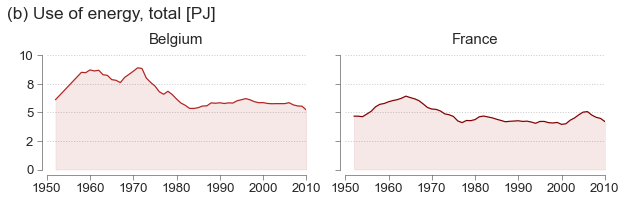

In [171]:
# Energy use, total:
ncols = len(countries)

fig, axes = plt.subplots(nrows=1, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(10, 2.1))

for col, country in enumerate(countries):
    ax = axes[col]
    if country == 'Belgium':
        color = 'firebrick'
    else:
        color = 'maroon'

    (be_fr[('Total energy use, architectural glass [TJ]', country)]
     .interpolate(method="linear", limit_area='inside')
     .rolling(5, center=True).mean()
     .plot(ax=ax, c=color))

    x = be_fr.index
    y = (be_fr[('Total energy use, architectural glass [TJ]', country)]
         .interpolate(method="linear", limit_area='inside')
         .rolling(5, center=True).mean())
    ax.fill_between(x, y, color="firebrick", alpha=0.1)

    # Divide by 1000 the y-axis, results in PJ
    ax.yaxis.set_major_formatter(y_1000)

    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
    style_ax(ax)
    ax.set_title(country, y=1.05)

ax.set_xlim(1950, 2010)
ax.set_ylim(0, 10000)

plt.xticks(np.arange(1950, 2011, 10))

fig.suptitle("(b) Use of energy, total [PJ]",
             x=0.07, y=1.2, ha='left')
fig.subplots_adjust(wspace=0.15, hspace=0.4)

sns.despine(offset=5)
plt.show()

if export:
    # Save image:
    fig.savefig(os.path.join(path_img, 'AppendixE_BEFR_Total enrgy.png'),
                dpi=600, bbox_inches='tight')
    fig.savefig(os.path.join(path_img, 'AppendixE_BEFR_Total enrgy.pdf'),
                bbox_inches='tight')

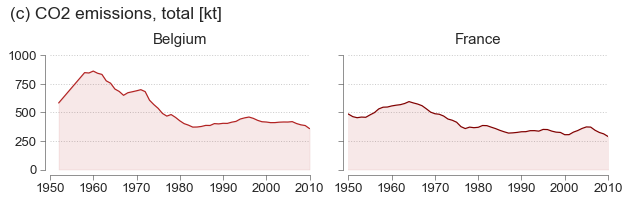

In [172]:
# CO2 emissions, total:
ncols = len(countries)

fig, axes = plt.subplots(nrows=1, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(10, 2.1))

for col, country in enumerate(countries):
    ax = axes[col]
    ax = axes[col]
    if country == 'Belgium':
        color = 'firebrick'
    else:
        color = 'maroon'

    (be_fr[('CO2, architectural glass [kt]', country)]
     .interpolate(method="linear", limit_area='inside')
     .rolling(5, center=True).mean()
     .plot(ax=ax, c=color))

    x = be_fr.index
    y = (be_fr[('CO2, architectural glass [kt]', country)]
         .interpolate(method="linear", limit_area='inside')
         .rolling(5, center=True).mean())
    ax.fill_between(x, y, color="firebrick", alpha=0.1)

    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
    style_ax(ax)
    ax.set_title(country, y=1.05)

ax.set_xlim(1950, 2010)
ax.set_ylim(0, 1000)

plt.xticks(np.arange(1950, 2011, 10))

fig.suptitle("(c) CO2 emissions, total [kt]",
             x=0.07, y=1.2, ha='left')
fig.subplots_adjust(wspace=0.15, hspace=0.4)

sns.despine(offset=5)
plt.show()

if export:
    # Save image:
    fig.savefig(os.path.join(path_img, 'AppendixE_BEFR_TotalCO2.png'),
                dpi=600, bbox_inches='tight')
    fig.savefig(os.path.join(path_img, 'AppendixE_BEFR_TotalCO2.pdf'),
                bbox_inches='tight')

In [173]:
(be_fr[('CO2, architectural glass [kt]', 'France')]
 .interpolate(method="linear", limit_area='inside')
 .rolling(5, center=True).mean())[2010]

289.40848192628147

# Relative v. Absolute Decoupling: A Base 100 Analysis

## Flat Glass Production, France and Belgium, 1960-1980

In [174]:
D1 = 1960
D2 = 1980

In [175]:
# Base 100 = 1960
FGProd_diff = (100 * be_fr['Production [kt]']
               / be_fr['Production [kt]'].loc[D1])

co2intensity_diff = 100 * fr_co2_intensity / fr_co2_intensity.loc[D1]

co2abs_diff = (100 * be_fr['CO2, flat glass [kt]']
               / be_fr['CO2, flat glass [kt]'].loc[D1])

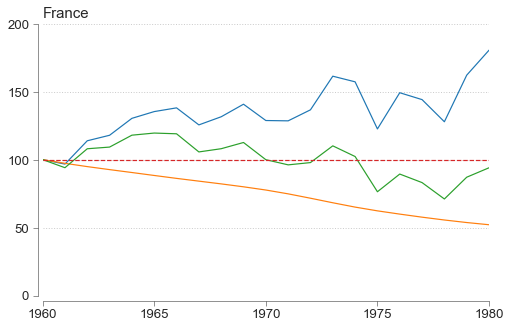

In [176]:
# Plot production, carbon intensity and CO2 absolute emissions for France:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=FGProd_diff,
             x=FGProd_diff.index,
             y='France',
             ax=ax)

ax.plot(co2intensity_diff.index,
        co2intensity_diff['CO2 interpolated [kg/t]'])

ax.plot(co2abs_diff.index,
        co2abs_diff['France'])

ax.plot([D1, D2], [100, 100], '--')
ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

ax.set_ylim(0, 200)
plt.yticks(np.arange(0, 201, 50))
ax.set_xlim(D1, D2)
plt.xticks(np.arange(D1, D2+1, 5))

ax.set_title("France", loc='left')
ax.set_ylabel(None)
style_ax(ax)

sns.despine(offset=5)
plt.show()

In [177]:
# Base 100 = 1960, with a 5-year moving average
fg_prod_diffroll = (100 * be_fr['Production [kt]']
                    .interpolate(method="linear", limit_area='inside')
                    .rolling(5, center=True).mean()
                    / be_fr['Production [kt]']
                    .interpolate(method="linear", limit_area='inside')
                    .rolling(5, center=True).mean().loc[D1])

co2abs_diffroll = (100 * (be_fr['CO2, flat glass [kt]']
                          .interpolate(method="linear", limit_area='inside')
                          .rolling(5, center=True).mean())
                   / (be_fr['CO2, flat glass [kt]']
                       .interpolate(method="linear", limit_area='inside')
                       .rolling(5, center=True).mean().loc[D1]))

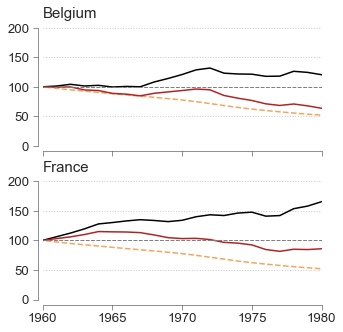

In [178]:
# Plot production, carbon intensity, CO2 absolute emissions for France:
fig, axes = plt.subplots(nrows=2, ncols=1,
                         sharex=True, sharey=True,
                         figsize=(5, 5))


for col, country in enumerate(countries):
    ax = axes[col]

    sns.lineplot(data=fg_prod_diffroll,
                 x=fg_prod_diffroll.index,
                 y=f'{country}',
                 ax=ax, color='black', linewidth=1.5)

    ax.plot(co2intensity_diff.index,
            co2intensity_diff['CO2 interpolated [kg/t]'],
            color='sandybrown', linestyle='--', linewidth=1.5)

    ax.plot(co2abs_diffroll.index,
            co2abs_diffroll[f'{country}'],
            color='firebrick', linewidth=1.5)

    ax.set_xlim(D1, D2)
    plt.xticks(np.arange(D1, D2+1, 5))
    ax.set_ylabel(None)

    ax.plot([D1, D2], [100, 100], '--', c='grey', linewidth=1)
    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

    ax.set_title(f"{country}", loc='left', pad=10)
    style_ax(ax)

ax.set_ylim(0, 200)
plt.yticks(np.arange(0, 201, 50))

fig.subplots_adjust(hspace=0.3)

sns.despine(offset=5)
plt.show()

if export:
    # Save image:
    fig.savefig(os.path.join(path_img, 'be_fr_FlatGlass_Base100_60-80.png'),
                dpi=600, bbox_inches='tight')
    fig.savefig(os.path.join(path_img, 'be_fr_FlatGlass_Base100_60-80.pdf'),
                bbox_inches='tight')

In [179]:
for country in countries:
    print(f"Flat Glass Prod in {country}:\n",
          '%.2f' % fg_prod_diffroll[f'{country}'].loc[D2])
    print(f"CO2 absolute emissions in {country}:\n",
          '%.2f' % co2abs_diffroll[f'{country}'].loc[D2])
    print("CO2 intensity:\n",
          '%.2f' % co2intensity_diff['CO2 interpolated [kg/t]'].loc[D2])

Flat Glass Prod in Belgium:
 120.41
CO2 absolute emissions in Belgium:
 63.65
CO2 intensity:
 52.07
Flat Glass Prod in France:
 165.57
CO2 absolute emissions in France:
 85.88
CO2 intensity:
 52.07


## Flat Glass Production, France and Belgium, 1985-2005

In [180]:
D3 = 1985
D4 = 2005

In [181]:
# Base 100 = 1985
FGProd_diff = (100 * be_fr['Production [kt]']
               / be_fr['Production [kt]'].loc[D3])

co2intensity_diff = 100 * fr_co2_intensity / fr_co2_intensity.loc[D3]

co2abs_diff = (100 * be_fr['CO2, flat glass [kt]']
               / be_fr['CO2, flat glass [kt]'].loc[D3])

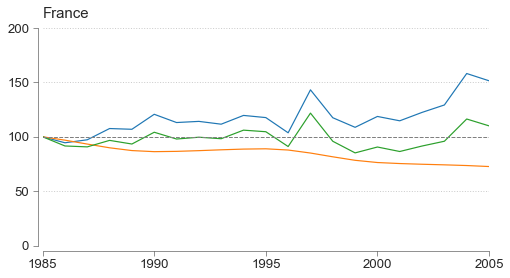

In [182]:
# Plot production, carbon intensity and CO2 absolute emissions for France:
fig, ax = plt.subplots(figsize=(8, 4))

sns.lineplot(data=FGProd_diff,
             x=FGProd_diff.index,
             y='France',
             ax=ax)

ax.plot(co2intensity_diff.index,
        co2intensity_diff['CO2 interpolated [kg/t]'])
ax.plot(co2abs_diff.index,
        co2abs_diff['France'])

ax.plot([D3, D4], [100, 100], '--', c='grey', linewidth=1)
ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

ax.set_ylim(0, 200)
plt.yticks(np.arange(0, 201, 50))
ax.set_xlim(D3, D4)
plt.xticks(np.arange(D3, D4+1, 5))

ax.set_title("France", loc='left', pad=10)
ax.set_ylabel(None)
style_ax(ax)

sns.despine(offset=5)
plt.show()

In [183]:
# Base 100 = 1985, with a 5-year rolling
fg_prod_diffroll = (100 * be_fr['Production [kt]']
                    .rolling(5, center=True).mean()
                    / be_fr['Production [kt]']
                    .rolling(5, center=True).mean().loc[D3])

co2abs_diffroll = (100 * (be_fr['CO2, flat glass [kt]']
                          .interpolate(method="linear", limit_area='inside')
                          .rolling(5, center=True).mean())
                   / (be_fr['CO2, flat glass [kt]']
                       .interpolate(method="linear", limit_area='inside')
                       .rolling(5, center=True).mean().loc[D3]))

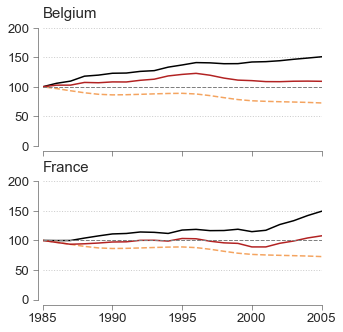

In [184]:
# Plot production, carbon intensity, CO2 absolute emissions for France:
fig, axes = plt.subplots(nrows=2, ncols=1,
                         sharex=True, sharey=True,
                         figsize=(5, 5))

for col, country in enumerate(countries):
    ax = axes[col]

    sns.lineplot(data=fg_prod_diffroll,
                 x=fg_prod_diffroll.index,
                 y=f'{country}',
                 ax=ax, color='black', linewidth=1.5)

    ax.plot(co2intensity_diff.index,
            co2intensity_diff['CO2 interpolated [kg/t]'],
            color='sandybrown', linestyle='--', linewidth=1.5)

    ax.plot(co2abs_diffroll.index,
            co2abs_diffroll[f'{country}'],
            color='firebrick', linewidth=1.5)

    ax.set_xlim(D3, D4)
    plt.xticks(np.arange(D3, D4+1, 5))
    ax.set_ylabel(None)

    ax.plot([D3, D4], [100, 100], '--', c='grey', linewidth=1)
    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

    ax.set_title(f"{country}", loc='left', pad=10)
    style_ax(ax)

ax.set_ylim(0, 200)
plt.yticks(np.arange(0, 201, 50))

fig.subplots_adjust(hspace=0.3)

sns.despine(offset=5)
plt.show()

if export:
    # Save image:
    fig.savefig(os.path.join(path_img, 'be_fr_FlatGlass_Base100_85-05.png'),
                dpi=600, bbox_inches='tight')
    fig.savefig(os.path.join(path_img, 'be_fr_FlatGlass_Base100_85-05.pdf'),
                bbox_inches='tight')

In [185]:
for country in countries:
    print(f"Flat Glass Prod in {country}:\n",
          '%.2f' % fg_prod_diffroll[f'{country}'].loc[D4])
    print(f"CO2 absolute emissions in {country}:\n",
          '%.2f' % co2abs_diffroll[f'{country}'].loc[D4])
    print("CO2 intensity:\n",
          '%.2f' % co2intensity_diff['CO2 interpolated [kg/t]'].loc[D4])

Flat Glass Prod in Belgium:
 150.80
CO2 absolute emissions in Belgium:
 109.27
CO2 intensity:
 72.63
Flat Glass Prod in France:
 149.35
CO2 absolute emissions in France:
 107.78
CO2 intensity:
 72.63


## Architectural Glass Production, France and Belgium, 1960-1980

In [186]:
# Base 100 = 1960
FGProd_diff = (100 * be_fr['Architectural glass production [kt]']
               / be_fr['Architectural glass production [kt]'].loc[D1])

co2intensity_diff = 100 * fr_co2_intensity / fr_co2_intensity.loc[D1]

co2abs_diff = (100 * be_fr['CO2, architectural glass [kt]']
               / be_fr['CO2, architectural glass [kt]'].loc[D1])

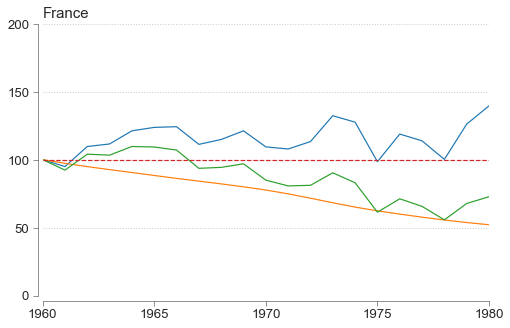

In [187]:
# Plot production, carbon intensity and CO2 absolute emissions for France:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=FGProd_diff,
             x=FGProd_diff.index,
             y='France',
             ax=ax)

ax.plot(co2intensity_diff.index,
        co2intensity_diff['CO2 interpolated [kg/t]'])

ax.plot(co2abs_diff.index,
        co2abs_diff['France'])

ax.plot([D1, D2], [100, 100], '--')
ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

ax.set_ylim(0, 200)
plt.yticks(np.arange(0, 201, 50))
ax.set_xlim(D1, D2)
plt.xticks(np.arange(D1, D2+1, 5))

ax.set_title("France", loc='left')
ax.set_ylabel(None)
style_ax(ax)

sns.despine(offset=5)
plt.show()

In [188]:
# Base 100 = 1960, with a 5-year moving average
fg_prod_diffroll = (100 * be_fr['Architectural glass production [kt]']
                    .interpolate(method="linear", limit_area='inside')
                    .rolling(5, center=True).mean()
                    / be_fr['Architectural glass production [kt]']
                    .interpolate(method="linear", limit_area='inside')
                    .rolling(5, center=True).mean().loc[D1])

co2abs_diffroll = (100 * (be_fr['CO2, architectural glass [kt]']
                          .interpolate(method="linear", limit_area='inside')
                          .rolling(5, center=True).mean())
                   / (be_fr['CO2, architectural glass [kt]']
                       .interpolate(method="linear", limit_area='inside')
                       .rolling(5, center=True).mean().loc[D1]))

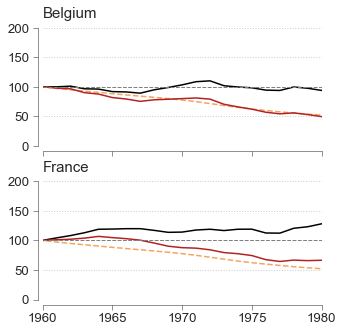

In [189]:
# Plot production, carbon intensity, CO2 absolute emissions for France:
fig, axes = plt.subplots(nrows=2, ncols=1,
                         sharex=True, sharey=True,
                         figsize=(5, 5))

for col, country in enumerate(countries):
    ax = axes[col]

    sns.lineplot(data=fg_prod_diffroll,
                 x=fg_prod_diffroll.index,
                 y=f'{country}',
                 ax=ax, color='black', linewidth=1.5)

    ax.plot(co2intensity_diff.index,
            co2intensity_diff['CO2 interpolated [kg/t]'],
            color='sandybrown', linestyle='--', linewidth=1.5)

    ax.plot(co2abs_diffroll.index,
            co2abs_diffroll[f'{country}'],
            color='firebrick', linewidth=1.5)

    ax.set_xlim(D1, D2)
    plt.xticks(np.arange(D1, D2+1, 5))
    ax.set_ylabel(None)

    ax.plot([D1, D2], [100, 100], '--', c='grey', linewidth=1)
    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

    ax.set_title(f"{country}", loc='left', pad=10)
    style_ax(ax)

ax.set_ylim(0, 200)
plt.yticks(np.arange(0, 201, 50))

fig.subplots_adjust(hspace=0.3)

sns.despine(offset=5)
plt.show()

if export:
    # Save image:
    fig.savefig(os.path.join(path_img, 'be_fr_ArchGlass_Base100_60-80.png'),
                dpi=600, bbox_inches='tight')
    fig.savefig(os.path.join(path_img, 'be_fr_ArchGlass_Base100_60-80.pdf'),
                bbox_inches='tight')

In [190]:
for country in countries:
    print(f"Architectural Glass Prod in {country}:\n",
          '%.2f' % fg_prod_diffroll[f'{country}'].loc[D2])
    print(f"CO2 absolute emissions in {country}:\n",
          '%.2f' % co2abs_diffroll[f'{country}'].loc[D2])
    print("CO2 intensity:\n",
          '%.2f' % co2intensity_diff['CO2 interpolated [kg/t]'].loc[D2])

Architectural Glass Prod in Belgium:
 93.85
CO2 absolute emissions in Belgium:
 49.50
CO2 intensity:
 52.07
Architectural Glass Prod in France:
 128.11
CO2 absolute emissions in France:
 66.39
CO2 intensity:
 52.07


## Architectural Glass Production, France and Belgium, 1985-2005

In [191]:
# Base 100 = 1985
FGProd_diff = (100 * be_fr['Architectural glass production [kt]']
               / be_fr['Architectural glass production [kt]'].loc[D3])

co2intensity_diff = 100 * fr_co2_intensity / fr_co2_intensity.loc[D3]

co2abs_diff = (100 * be_fr['CO2, architectural glass [kt]']
               / be_fr['CO2, architectural glass [kt]'].loc[D3])

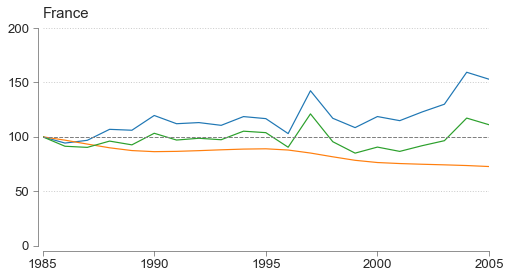

In [192]:
# Plot production, carbon intensity and CO2 absolute emissions for France:
fig, ax = plt.subplots(figsize=(8, 4))

sns.lineplot(data=FGProd_diff,
             x=FGProd_diff.index,
             y='France',
             ax=ax)

ax.plot(co2intensity_diff.index,
        co2intensity_diff['CO2 interpolated [kg/t]'])
ax.plot(co2abs_diff.index,
        co2abs_diff['France'])

ax.plot([D3, D4], [100, 100], '--', c='grey', linewidth=1)
ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

ax.set_ylim(0, 200)
plt.yticks(np.arange(0, 201, 50))
ax.set_xlim(D3, D4)
plt.xticks(np.arange(D3, D4+1, 5))

ax.set_title("France", loc='left', pad=10)
ax.set_ylabel(None)
style_ax(ax)

sns.despine(offset=5)
plt.show()

In [193]:
# Base 100 = 1985, with a 5-year rolling
fg_prod_diffroll = (100 * be_fr['Architectural glass production [kt]']
                    .rolling(5, center=True).mean()
                    / be_fr['Architectural glass production [kt]']
                    .rolling(5, center=True).mean().loc[D3])

co2abs_diffroll = (100 * (be_fr['CO2, architectural glass [kt]']
                          .interpolate(method="linear", limit_area='inside')
                          .rolling(5, center=True).mean())
                   / (be_fr['CO2, architectural glass [kt]']
                       .interpolate(method="linear", limit_area='inside')
                       .rolling(5, center=True).mean().loc[D3]))

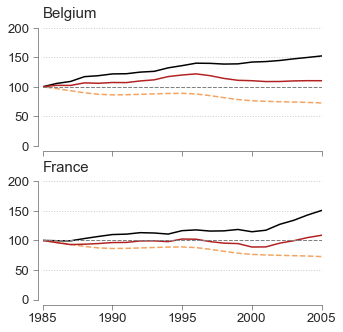

In [194]:
# Plot production, carbon intensity, CO2 absolute emissions for France:
fig, axes = plt.subplots(nrows=2, ncols=1,
                         sharex=True, sharey=True,
                         figsize=(5, 5))

for col, country in enumerate(countries):
    ax = axes[col]

    sns.lineplot(data=fg_prod_diffroll,
                 x=fg_prod_diffroll.index,
                 y=f'{country}',
                 ax=ax, color='black', linewidth=1.5)

    ax.plot(co2intensity_diff.index,
            co2intensity_diff['CO2 interpolated [kg/t]'],
            color='sandybrown', linestyle='--', linewidth=1.5)

    ax.plot(co2abs_diffroll.index,
            co2abs_diffroll[f'{country}'],
            color='firebrick', linewidth=1.5)

    ax.set_xlim(D3, D4)
    plt.xticks(np.arange(D3, D4+1, 5))
    ax.set_ylabel(None)

    ax.plot([D3, D4], [100, 100], '--', c='grey', linewidth=1)
    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

    ax.set_title(f"{country}", loc='left', pad=10)
    style_ax(ax)

ax.set_ylim(0, 200)
plt.yticks(np.arange(0, 201, 50))

fig.subplots_adjust(hspace=0.3)

sns.despine(offset=5)
plt.show()

if export:
    # Save image:
    fig.savefig(os.path.join(path_img, 'be_fr_ArchGlass_Base100_85-05.png'),
                dpi=600, bbox_inches='tight')
    fig.savefig(os.path.join(path_img, 'be_fr_ArchGlass_Base100_85-05.pdf'),
                bbox_inches='tight')

In [195]:
for country in countries:
    print(f"Architectural Glass Prod in {country}:\n",
          '%.2f' % fg_prod_diffroll[f'{country}'].loc[D4])
    print(f"CO2 absolute emissions in {country}:\n",
          '%.2f' % co2abs_diffroll[f'{country}'].loc[D4])
    print("CO2 intensity:\n",
          '%.2f' % co2intensity_diff['CO2 interpolated [kg/t]'].loc[D4])

Architectural Glass Prod in Belgium:
 152.20
CO2 absolute emissions in Belgium:
 110.26
CO2 intensity:
 72.63
Architectural Glass Prod in France:
 150.66
CO2 absolute emissions in France:
 108.70
CO2 intensity:
 72.63
